# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt

In [3]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
from pathlib import Path

from drvi_notebooks.utils.data.adata_plot_pp import make_balanced_subsample
from drvi_notebooks.utils.data.data_configs import get_data_info
from drvi_notebooks.utils.run_info import get_run_info_for_dataset
from drvi_notebooks.utils.method_info import pretify_method_name
from drvi_notebooks.utils.latent import set_optimal_ordering
from drvi_notebooks.utils.plotting import scatter_plot_per_latent

In [5]:
sc.set_figure_params(vector_friendly=True, dpi_save=300)

In [6]:
import mplscience
mplscience.available_styles()
mplscience.set_style()

['default', 'despine']


# Config

In [7]:
cwd = os.getcwd()
cwd

'/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public/drvi_notebooks/analysis'

In [8]:
proj_dir = Path(cwd).parent.parent
proj_dir

PosixPath('/ictstr01/home/icb/amirali.moinfar/projects/drvi_reproducibility_public')

In [9]:
(proj_dir / 'plots' / 'immune_ablation').mkdir(parents=True, exist_ok=True)

In [10]:
logs_dir = Path(os.path.expanduser('~/workspace/train_logs'))
logs_dir

PosixPath('/home/icb/amirali.moinfar/workspace/train_logs')

In [11]:
run_name = 'immune_hvg'
run_version = '4.3'
run_path = os.path.expanduser('~/workspace/train_logs/models')

data_info = get_data_info(run_name, run_version)
wandb_address = data_info['wandb_address']
col_mapping = data_info['col_mapping']
plot_columns = data_info['plot_columns']
pp_function = data_info['pp_function']
data_path = data_info['data_path']
var_gene_groups = data_info['var_gene_groups']
cell_type_key = data_info['cell_type_key']
exp_plot_pp = data_info['exp_plot_pp']
control_treatment_key = data_info['control_treatment_key']
condition_key = data_info['condition_key']
split_key = data_info['split_key']

In [12]:
cat_10_pallete = sc.plotting.palettes.vega_10_scanpy
cat_10_pallete_without_grey = [c for c in cat_10_pallete if c != '#7f7f7f']
cat_20_pallete = sc.plotting.palettes.vega_20_scanpy
wong_pallete = [
    "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000",
]
cat_100_pallete = sc.plotting.palettes.godsnot_102

## Data

In [13]:
adata = sc.read(data_path)
adata

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'gene_de_sig', 'mean', 'std'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'lognorm'
    obsp: 'connectivities', 'distances'

## Runs to load

In [14]:
run_info = get_run_info_for_dataset('immune_hvg_ablation')
RUNS_TO_LOAD = run_info.run_dirs
scatter_point_size = run_info.scatter_point_size
adata_to_transfer_obs = run_info.adata_to_transfer_obs

for k,v in RUNS_TO_LOAD.items():
    if not os.path.exists(v):
        raise ValueError(f"{v} does not exists.")

In [15]:
embeds = {}
random_order = None
for method_name, run_path in RUNS_TO_LOAD.items():
    print(method_name)
    embed = sc.read(run_path / 'latent.h5ad')
    pp_function(embed)
    set_optimal_ordering(embed, key_added='optimal_var_order')    
    if random_order is None:
        random_order = embed.obs.sample(frac=1.).index
    embed = embed[random_order].copy()
    embeds[method_name] = embed

2 Dimensional
4 Dimensional
6 Dimensional
8 Dimensional
10 Dimensional
12 Dimensional
14 Dimensional
16 Dimensional
32 Dimensional
64 Dimensional
128 Dimensional
256 Dimensional
512 Dimensional


In [16]:
# bad umap from rapids-single-cell on 2D emb
embed = embeds['2 Dimensional']
sc.pp.neighbors(embed, use_rep="qz_mean", n_neighbors=10, n_pcs=embed.obsm["qz_mean"].shape[1])
sc.tl.umap(embed, spread=1.0, min_dist=0.5, random_state=123)
sc.tl.pca(embed)

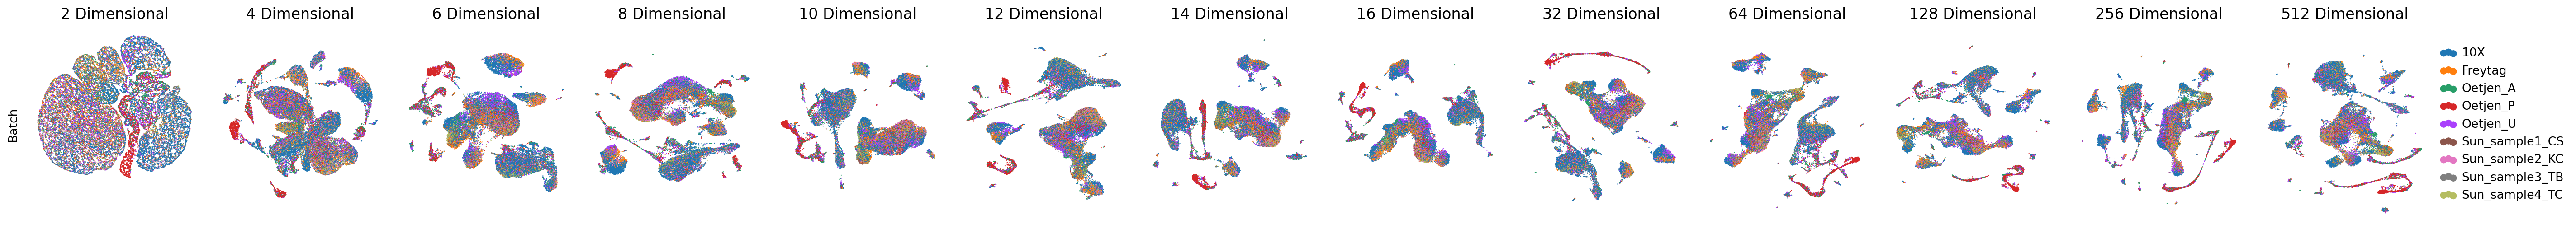

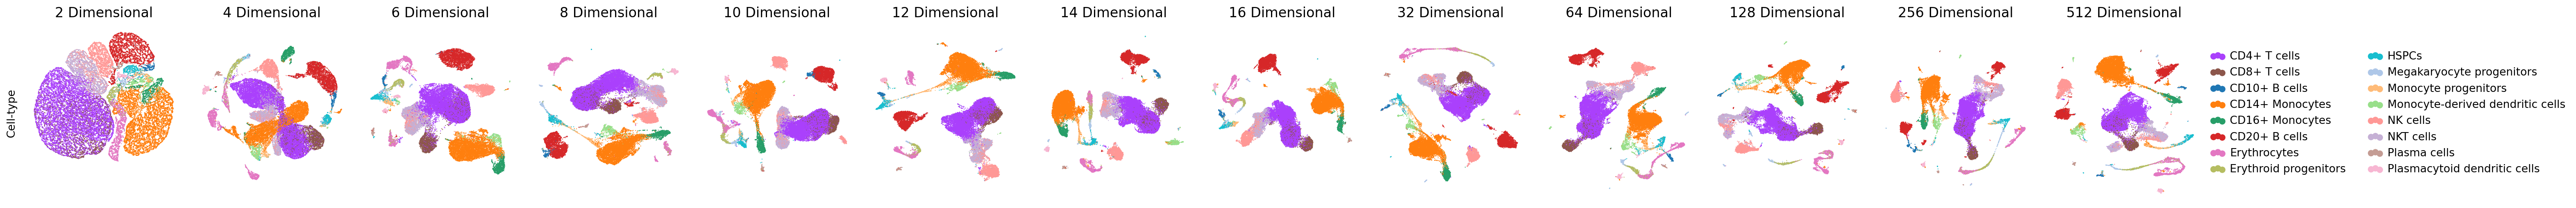

In [17]:
size = 3

for _, col in enumerate(plot_columns):
    fig,axs=plt.subplots(1, len(embeds),
                     figsize=(len(embeds) * size, 1 * size),
                     sharey='row', squeeze=False)
    j = 0
    for i, (method_name, embed) in enumerate(embeds.items()):
    
        pos = (-0.1, 0.5)
        
        ax = axs[j, i]
        unique_values = list(sorted(list(embed.obs[col].astype(str).unique())))
        # if len(unique_values) <= 8:
        #     palette = dict(zip(unique_values, wong_pallete))
        if len(unique_values) <= 10:
            palette = dict(zip(unique_values, cat_10_pallete))
        elif len(unique_values) <= 20:
            palette = dict(zip(unique_values, cat_20_pallete))
        elif len(unique_values) <= 102:
            palette = dict(zip(unique_values, cat_100_pallete))
        else:
            palette = None
        sc.pl.embedding(embed, 'X_umap',
                        color=col, 
                        palette=palette, 
                        ax=ax, show=False, frameon=False, title='' if j != 0 else method_name, 
                        legend_loc='none' if i != len(embeds) - 1 else 'right margin',
                        colorbar_loc=None if i != len(embeds) - 1 else 'right')
        if i == 0:
            ax.annotate(col_mapping[col], zorder=100, fontsize=12,
                        xy=pos, xytext=pos, textcoords='axes fraction', rotation='vertical', va='center', ha='center')

    plt.subplots_adjust(left=0.1,
                        bottom=0.05,
                        right=0.95,
                        top=0.95,
                        wspace=0.1,
                        hspace=0.1)   
    plt.savefig(proj_dir / 'plots' / 'immune_ablation' / f'plot_{run_name}_umaps_{col}.pdf', bbox_inches='tight')

2 Dimensional


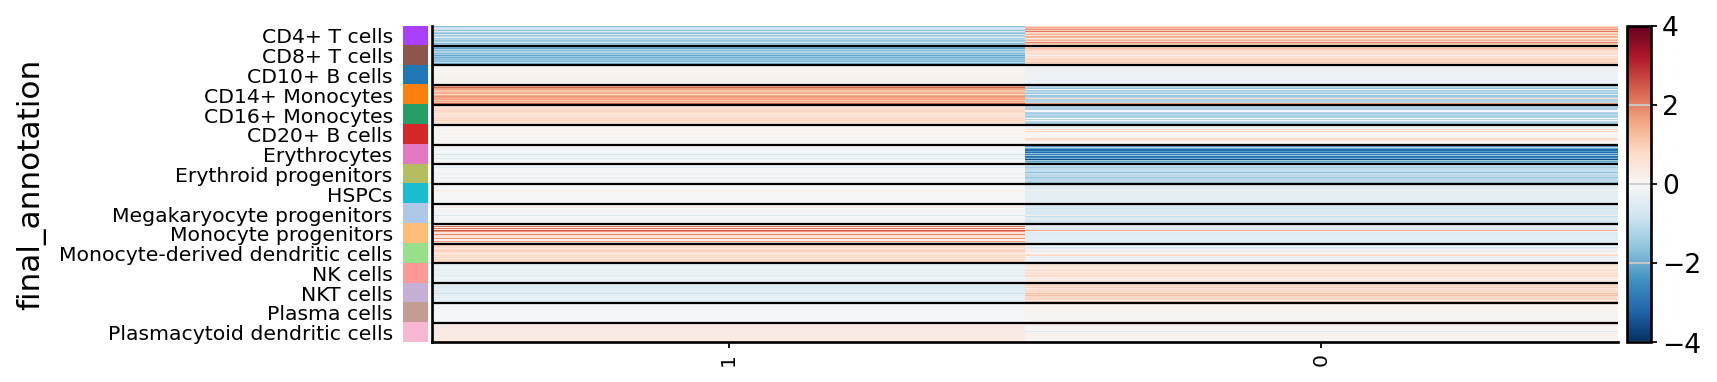

4 Dimensional


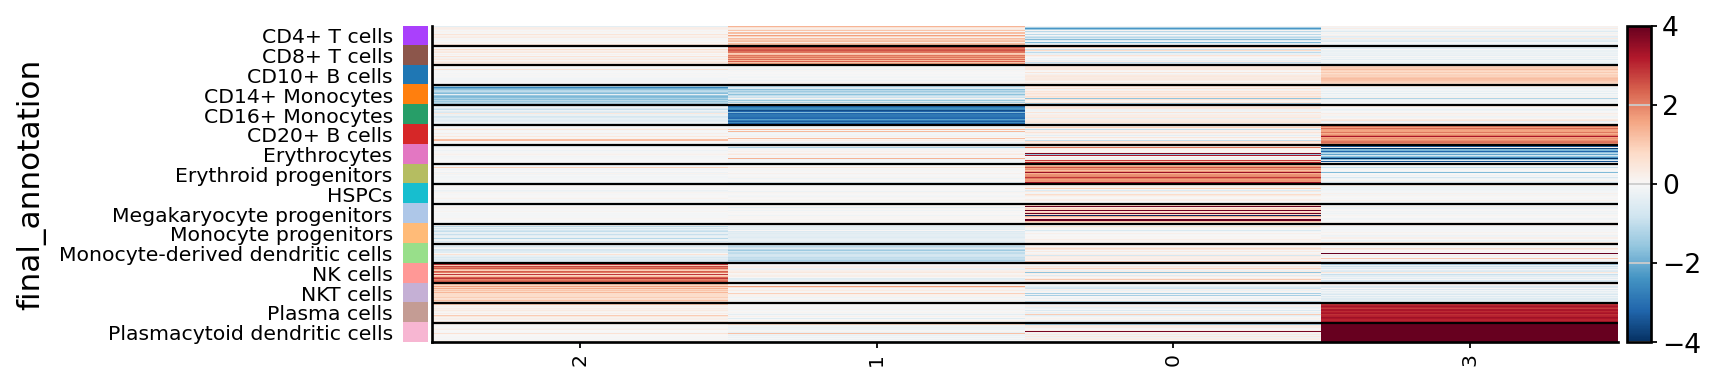

6 Dimensional


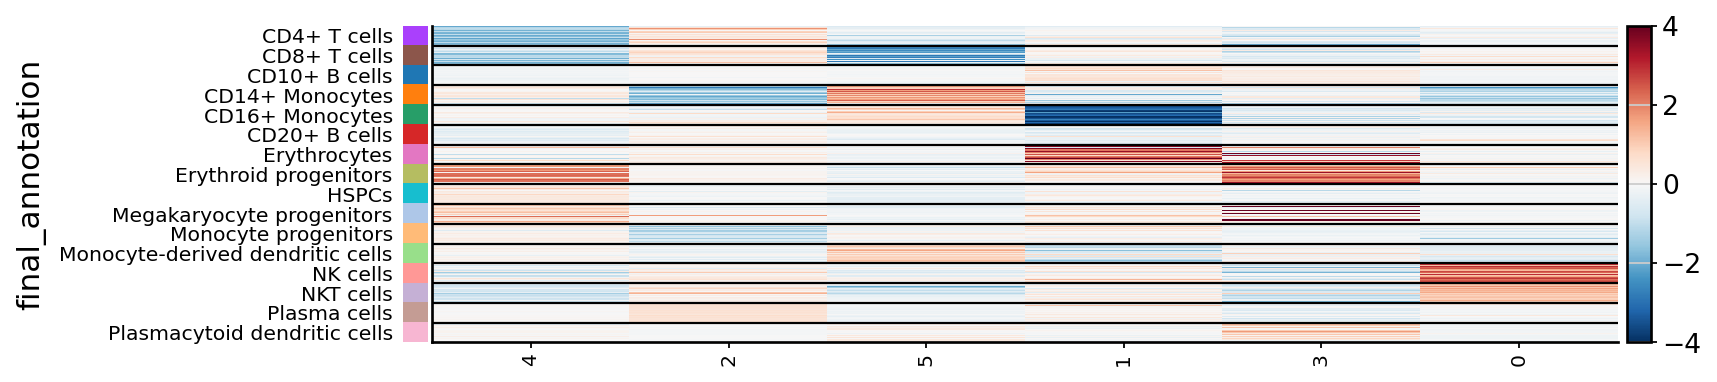

8 Dimensional


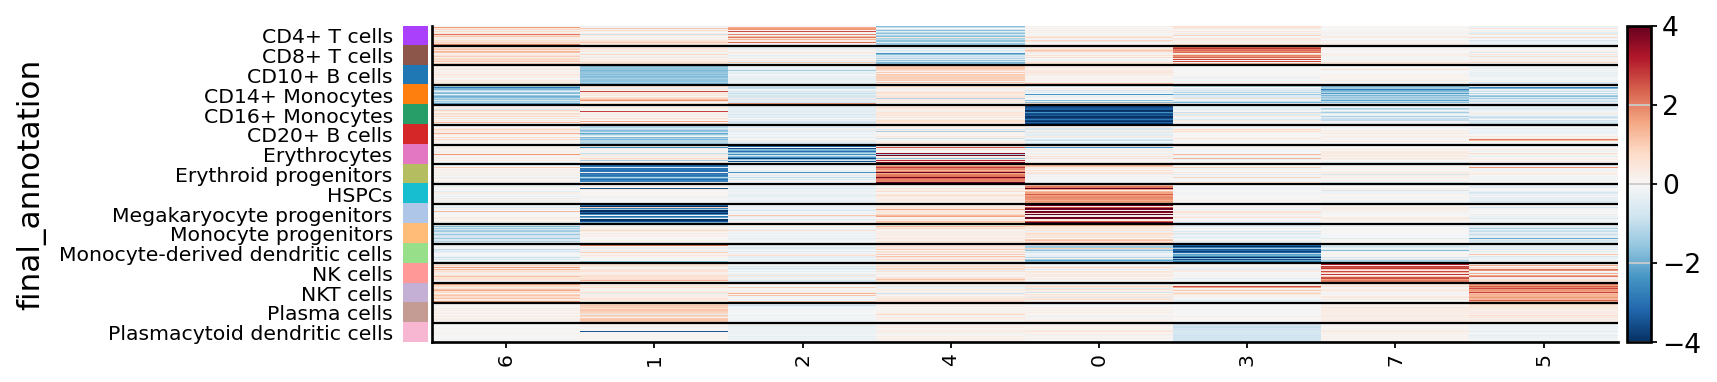

10 Dimensional


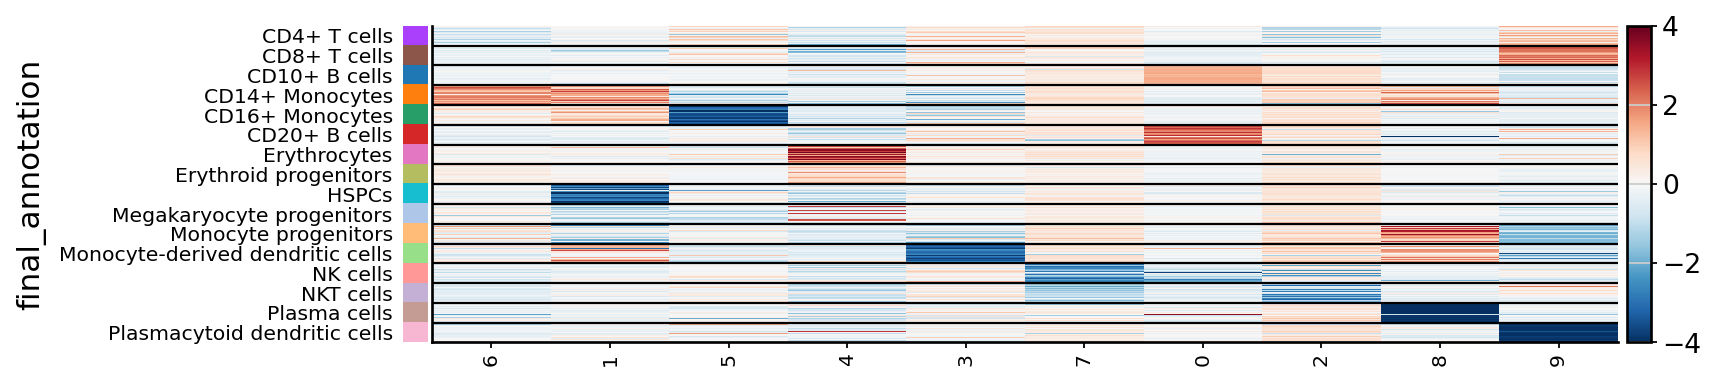

12 Dimensional


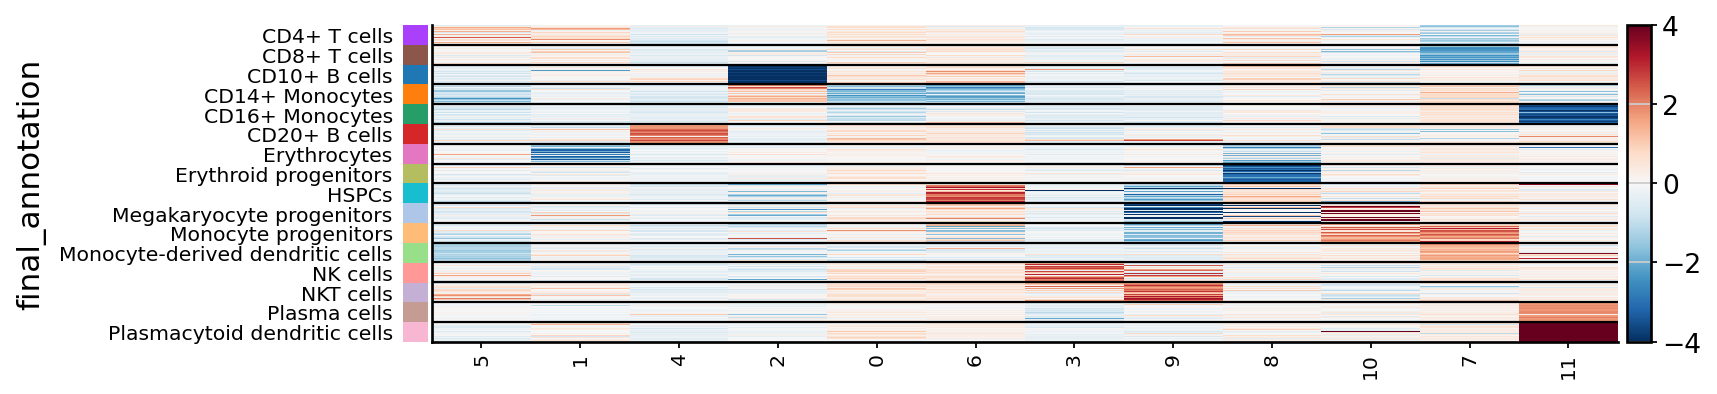

14 Dimensional


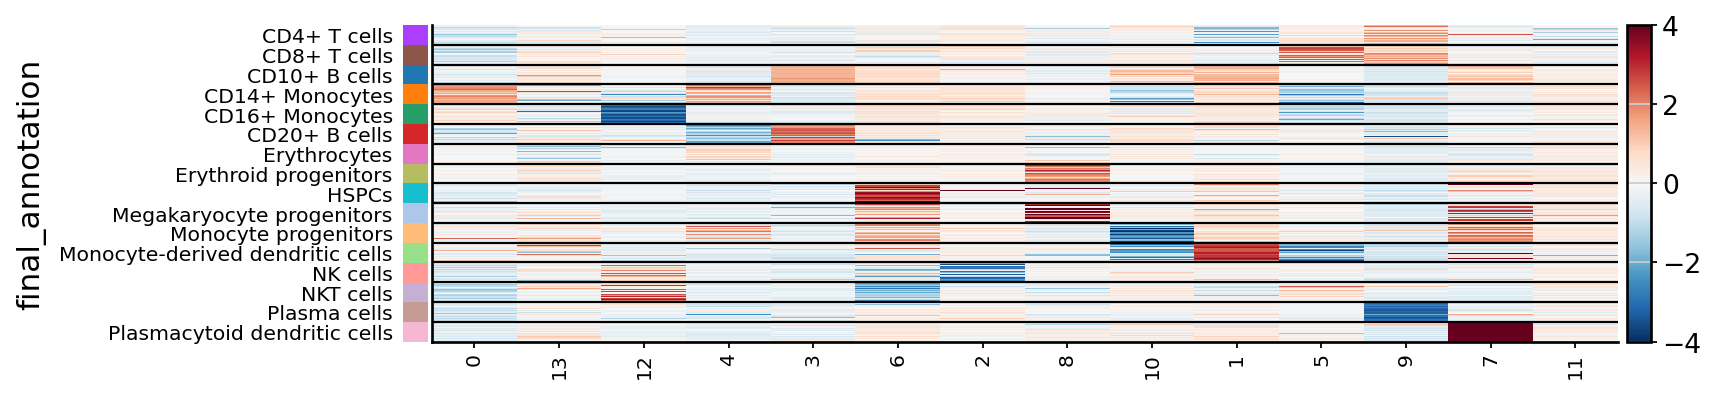

16 Dimensional


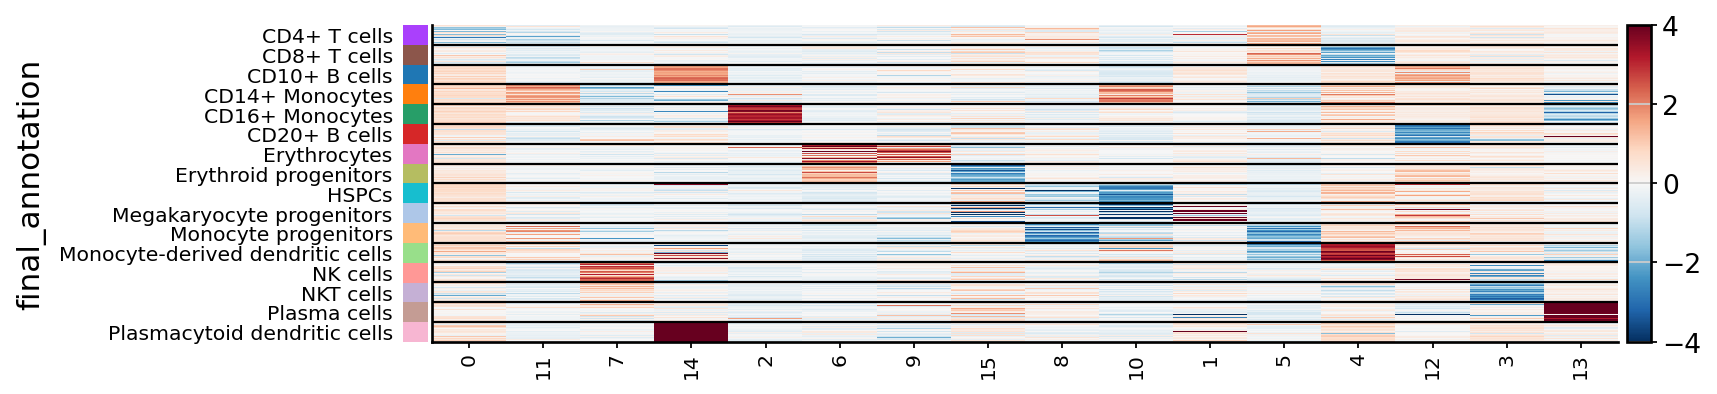

32 Dimensional


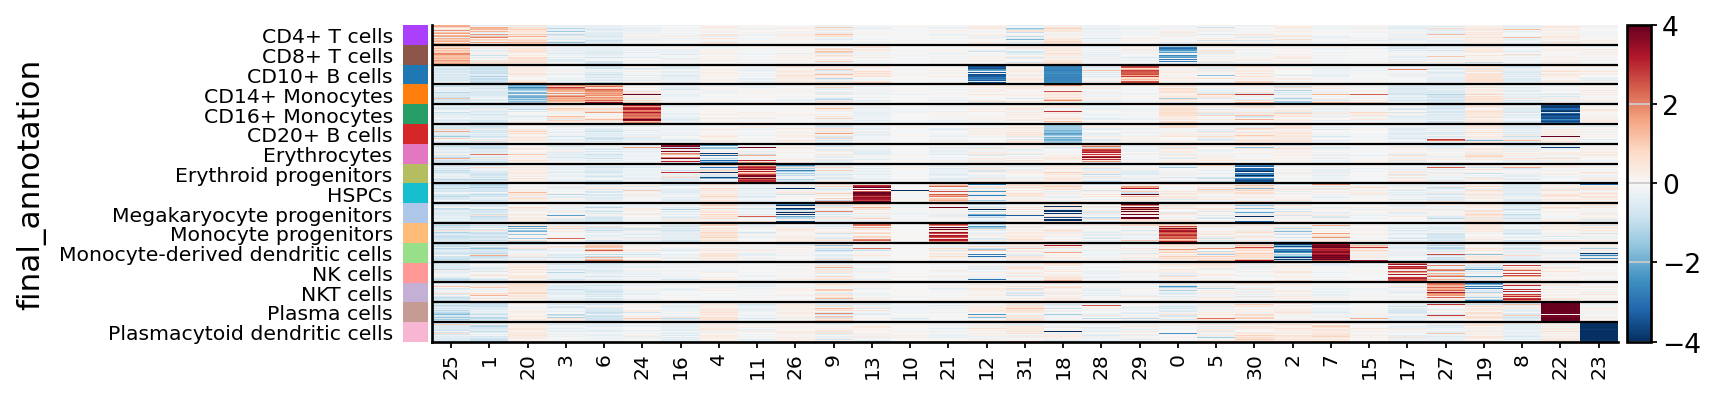

64 Dimensional


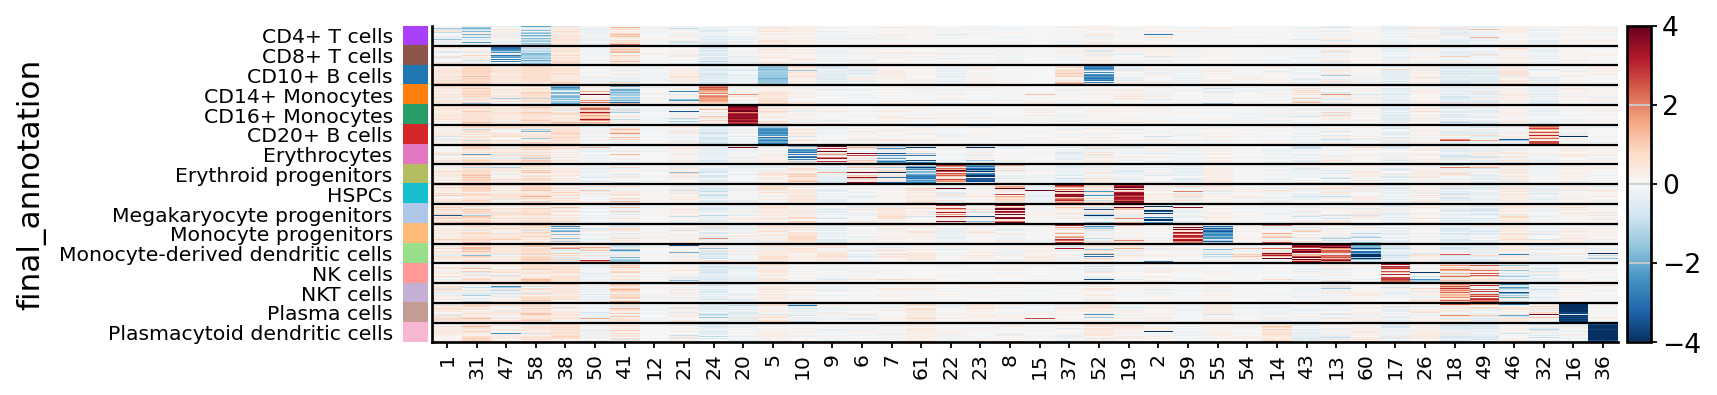

128 Dimensional


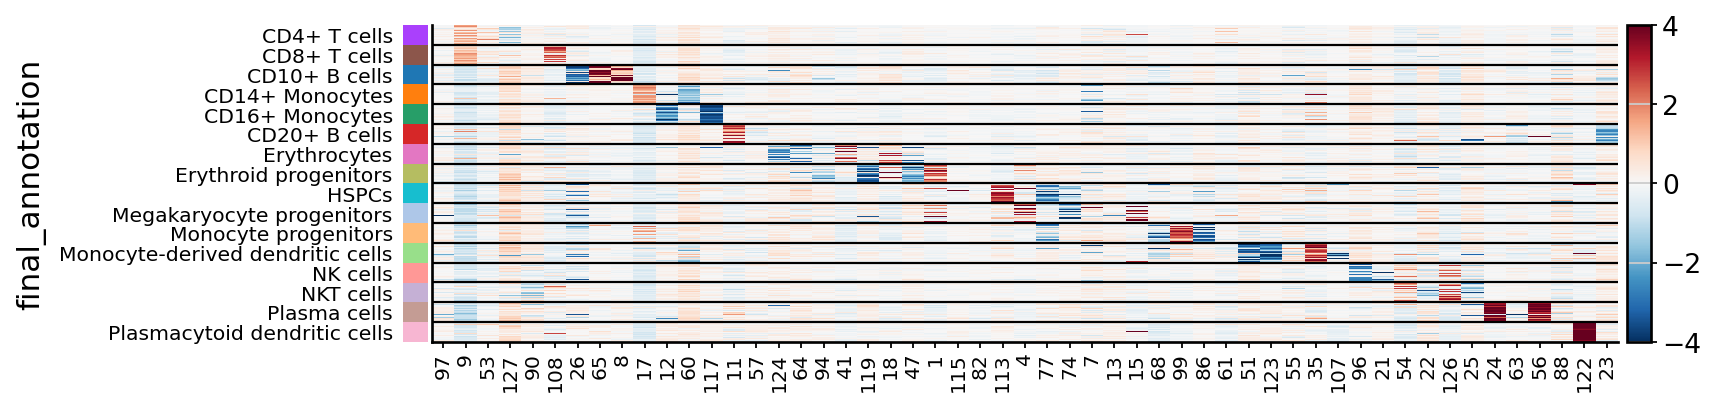

256 Dimensional


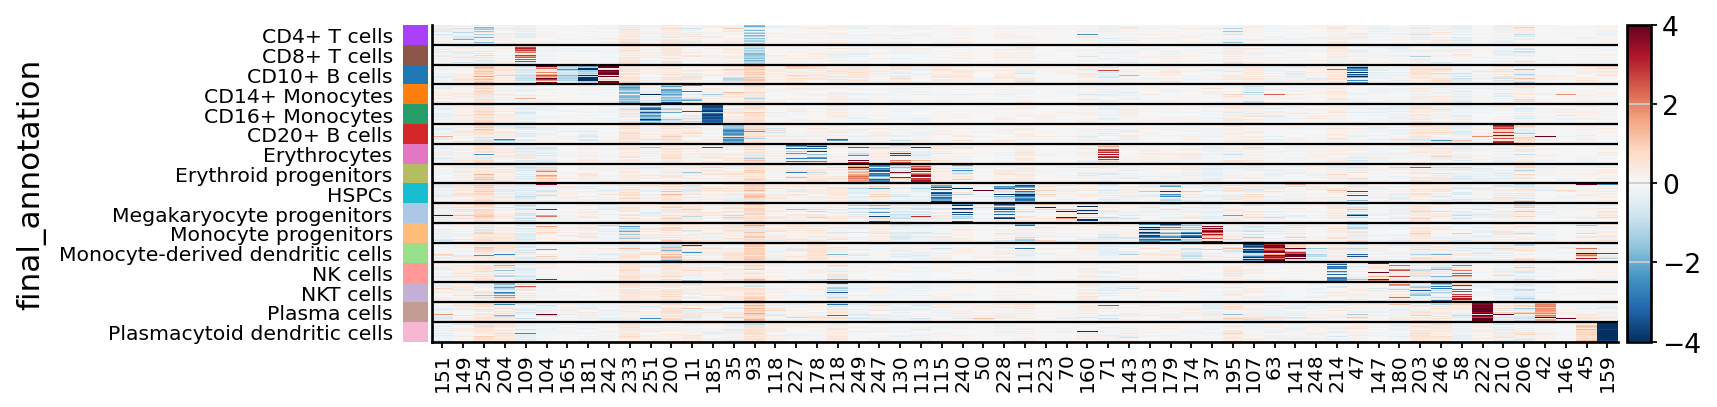

512 Dimensional


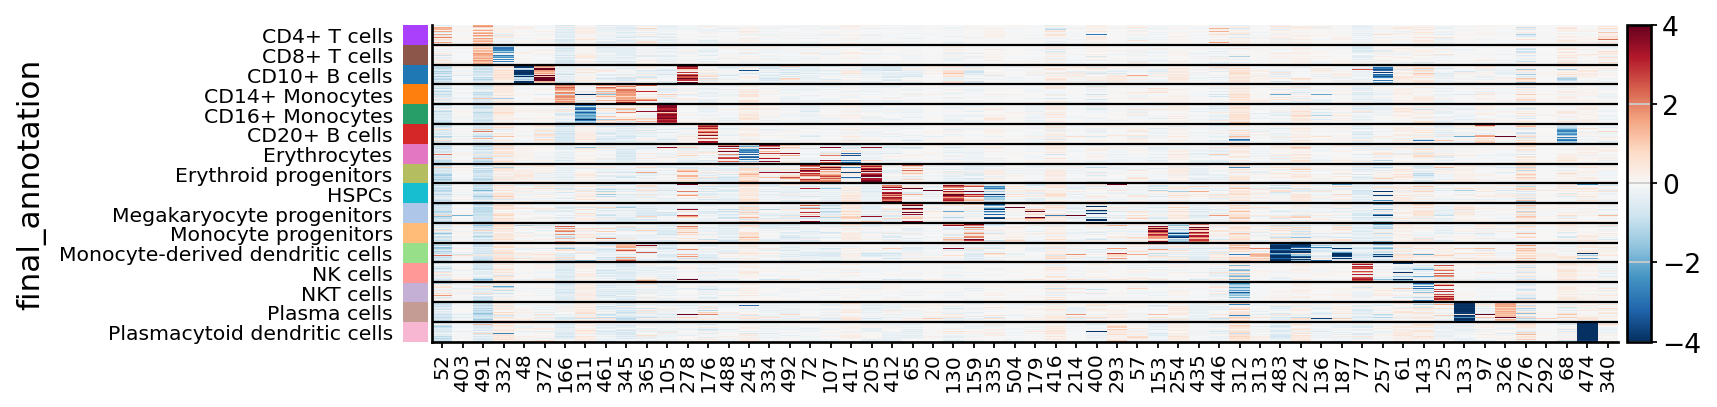

In [18]:
for method_name, embed in embeds.items():
    print(method_name)
    k = cell_type_key
    non_vanished_vars = np.arange(embed.n_vars)[np.abs(embed.X).max(axis=0) >= 0.1]
    embed_balanced = make_balanced_subsample(embed, k)
    dim_order = np.abs(embed_balanced.X).argmax(axis=0).argsort().tolist()
    sc.pl.heatmap(
        embed_balanced,
        embed.var.iloc[[x for x in dim_order if x in non_vanished_vars]].index,
        k,
        layer=None,
        figsize=(10, len(embed.obs[k].unique()) / 6),
        var_group_rotation=45,
        show_gene_labels=True,
        dendrogram=False,
        vcenter=0, vmin=-4, vmax=4,
        cmap='RdBu_r',
        show=False,
    )
    
    plt.savefig(proj_dir / 'plots' / 'immune_ablation' / f'heatmap_of_non_vanished_dims_{k}_{method_name}.pdf', bbox_inches='tight')
    plt.show()

# Number of vanished dimensions

2 Dimensional


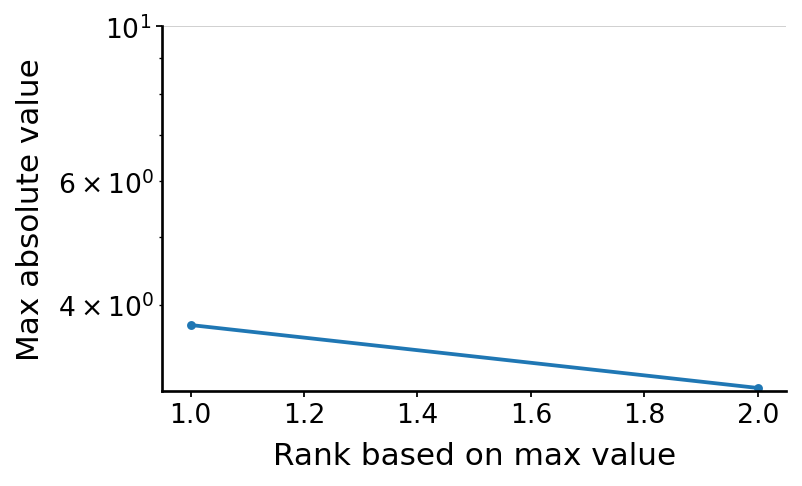

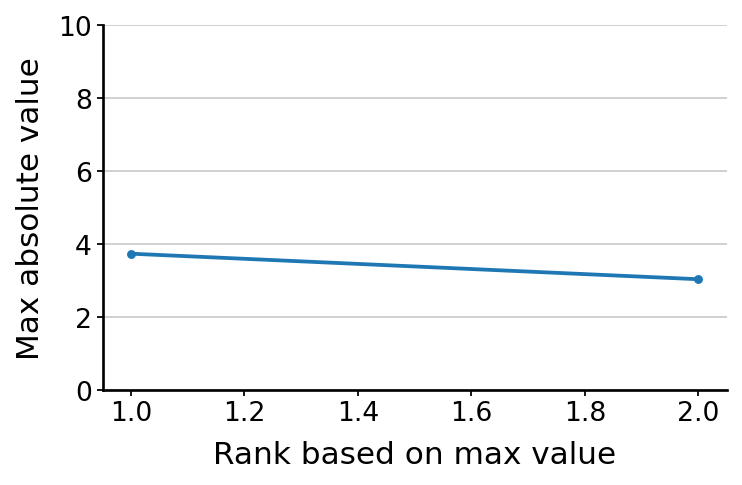

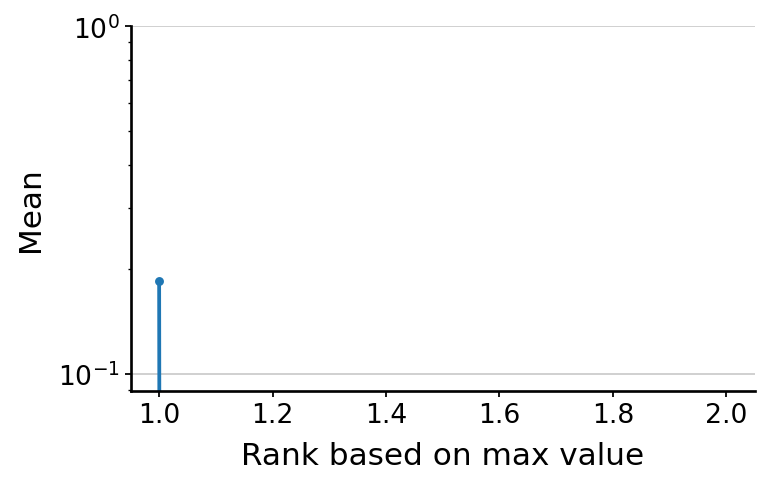

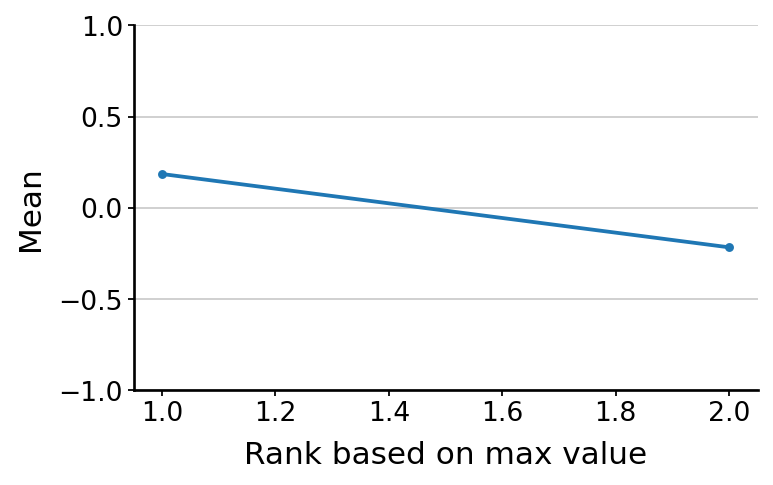

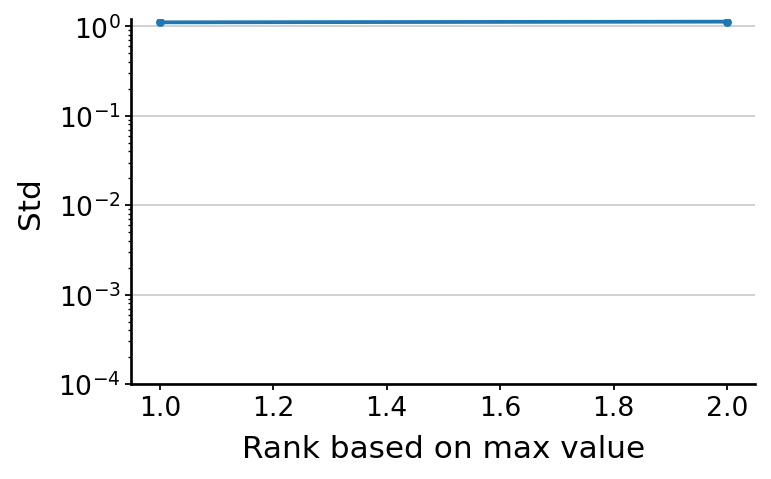

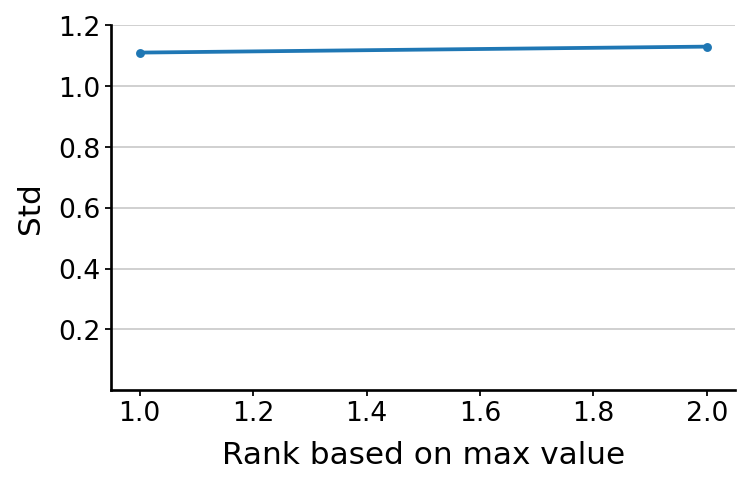

4 Dimensional


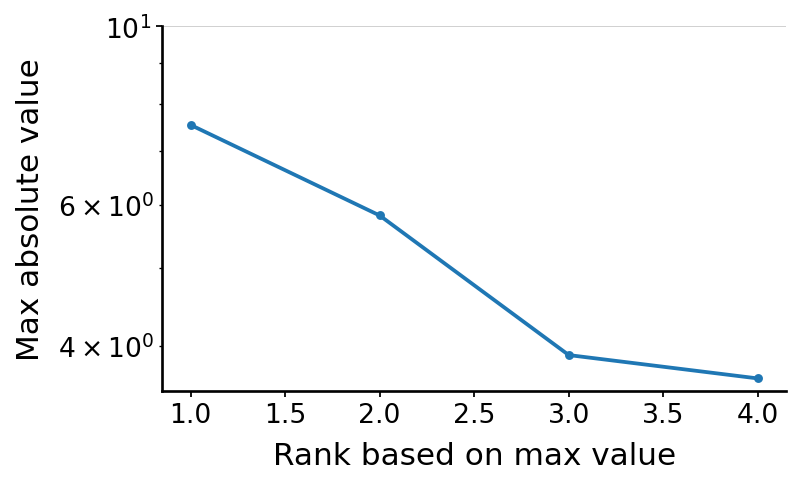

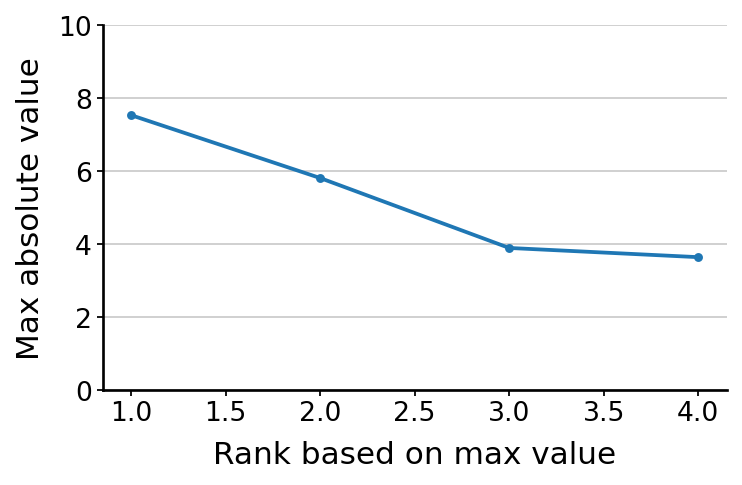

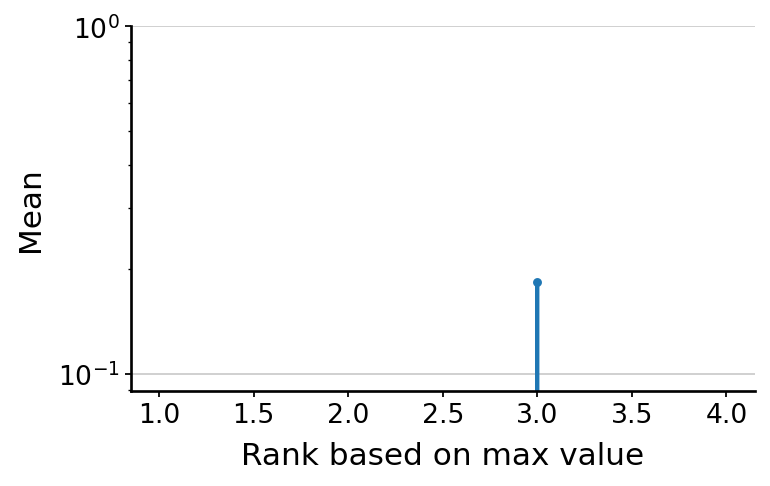

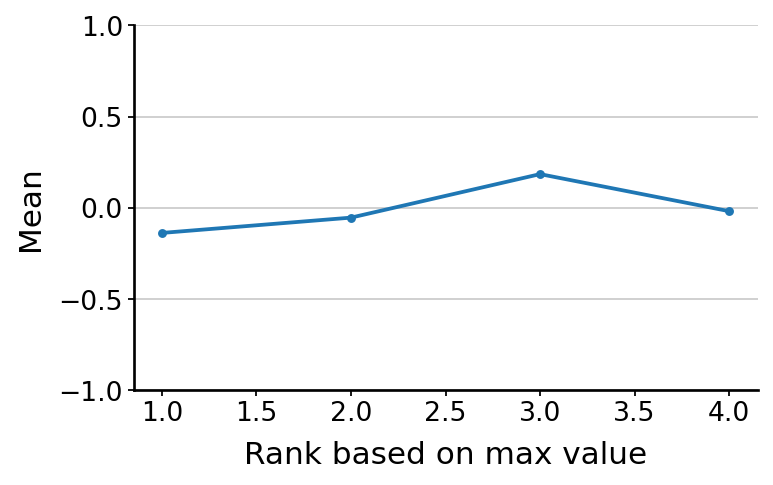

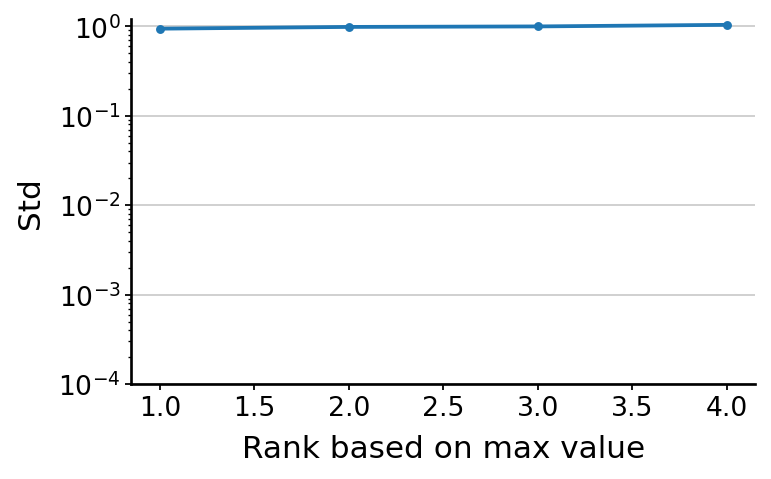

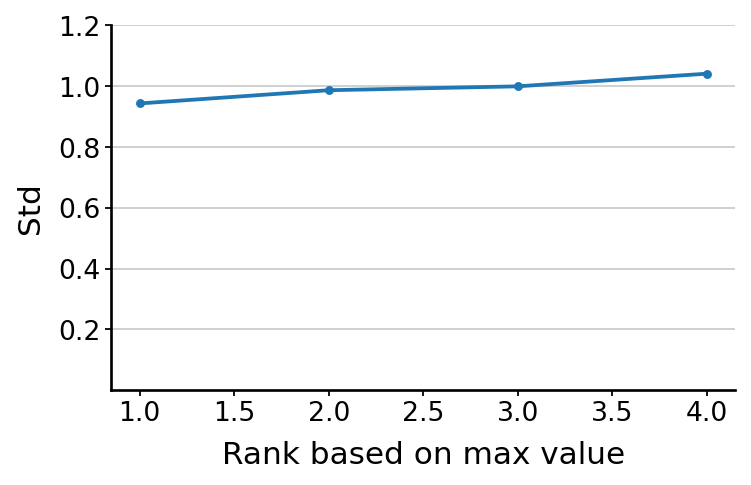

6 Dimensional


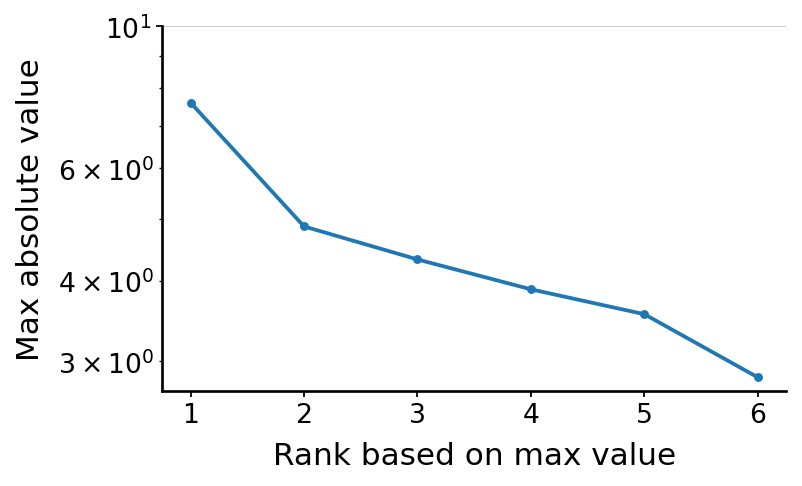

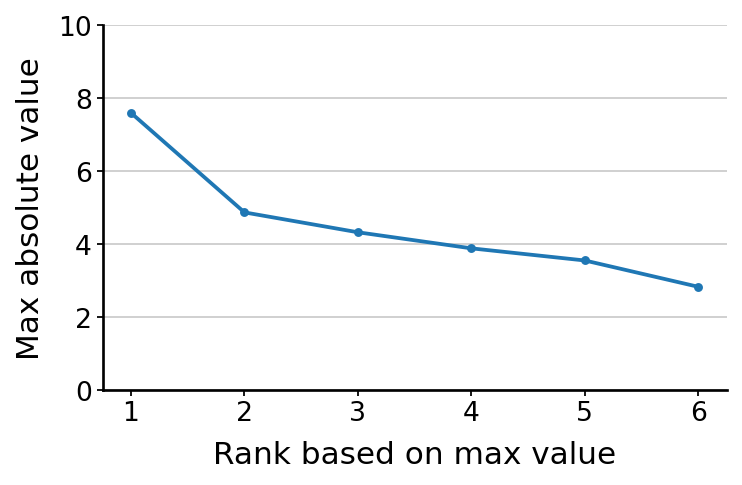

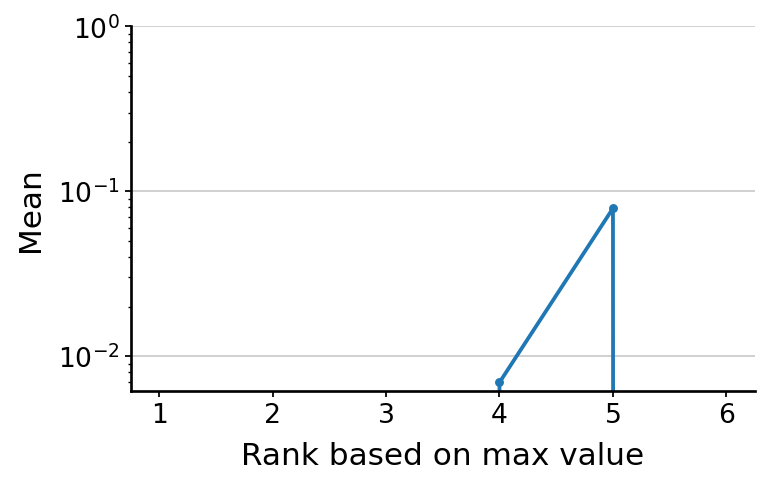

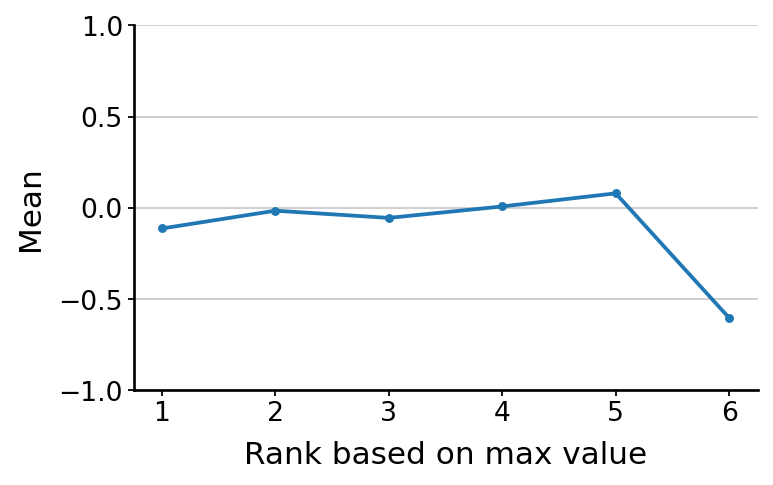

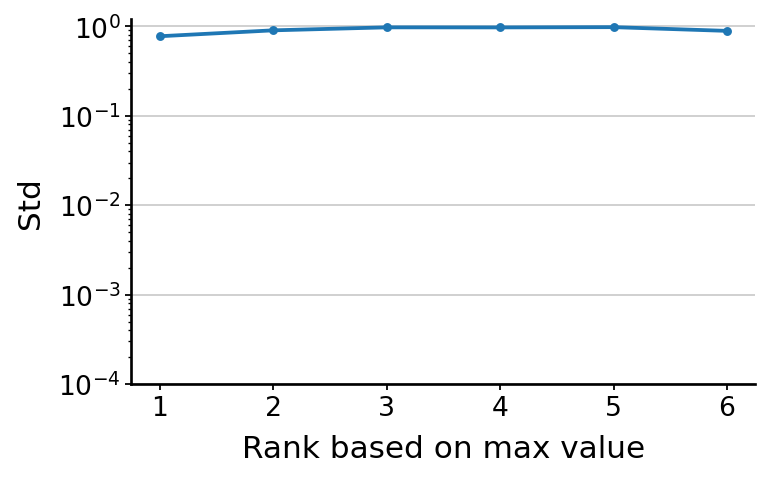

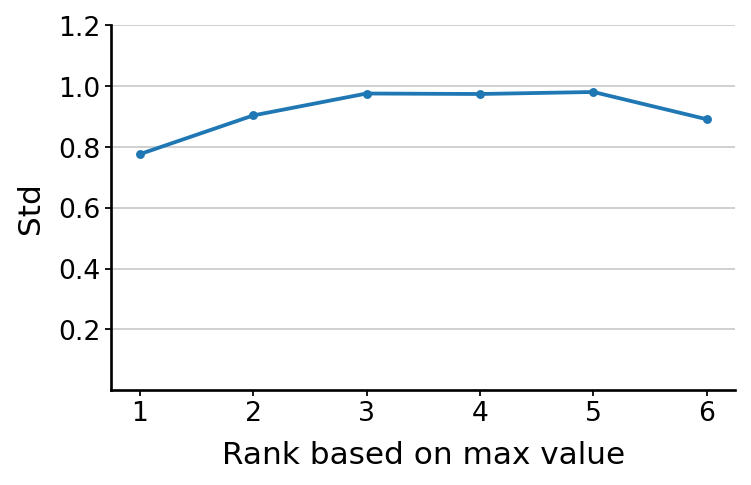

8 Dimensional


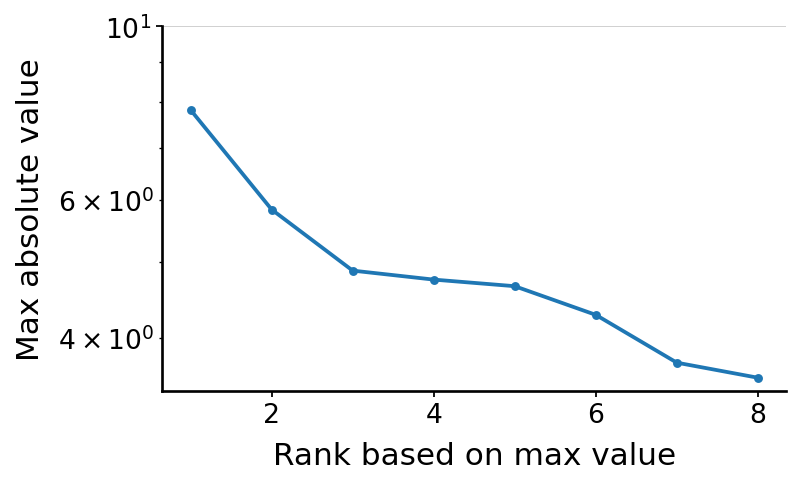

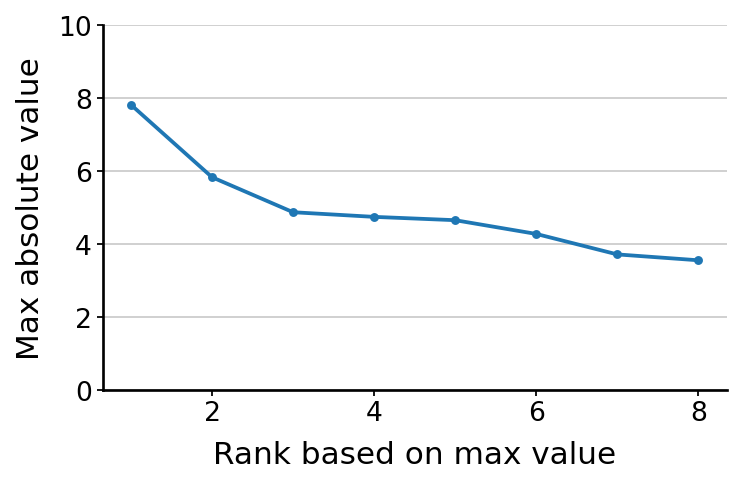

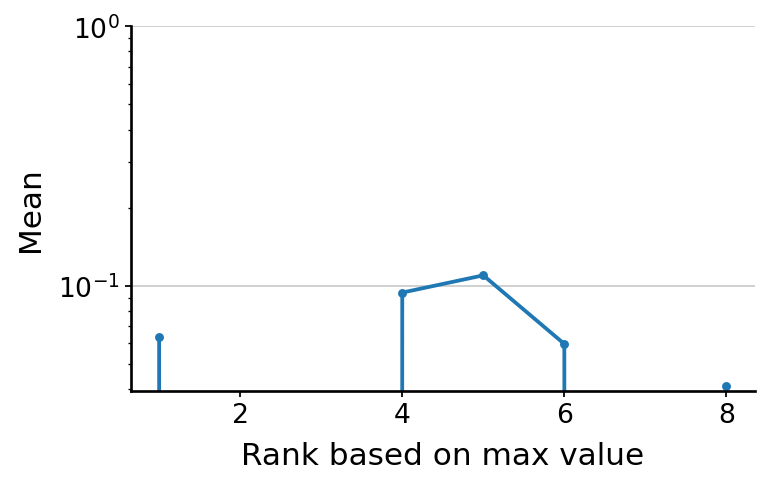

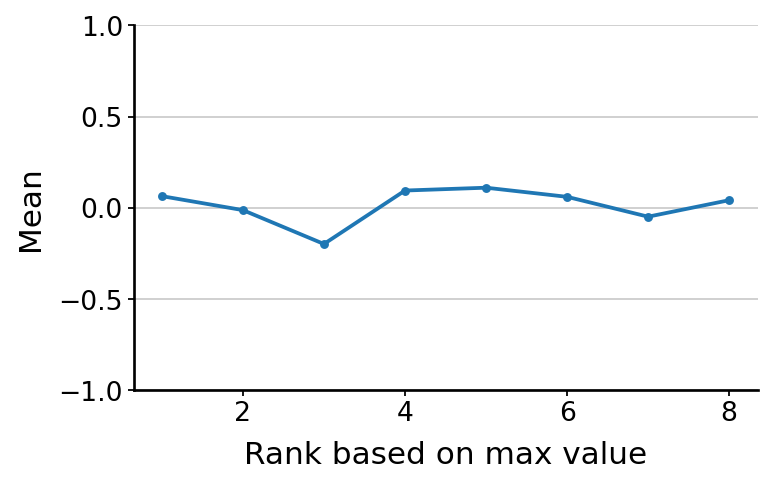

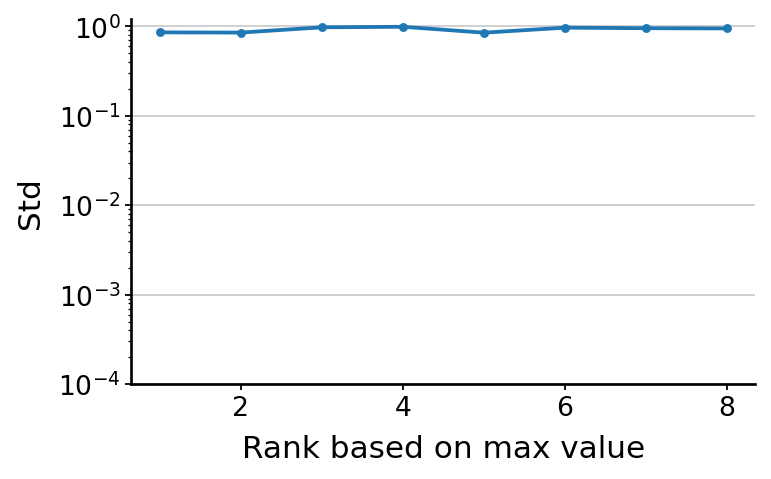

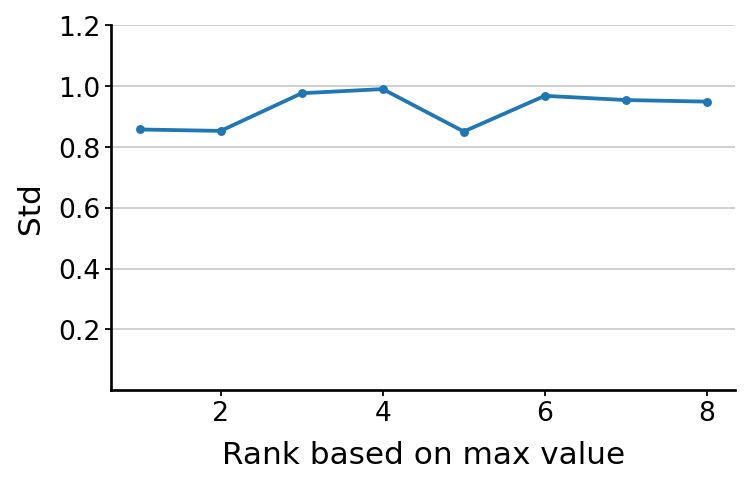

10 Dimensional


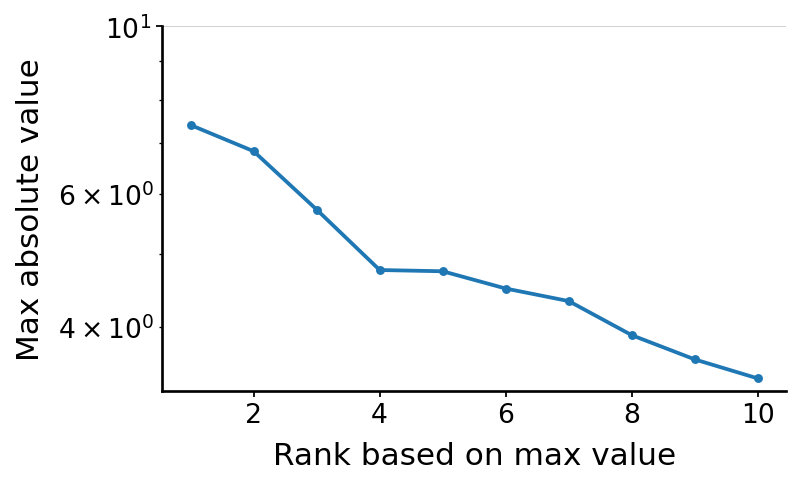

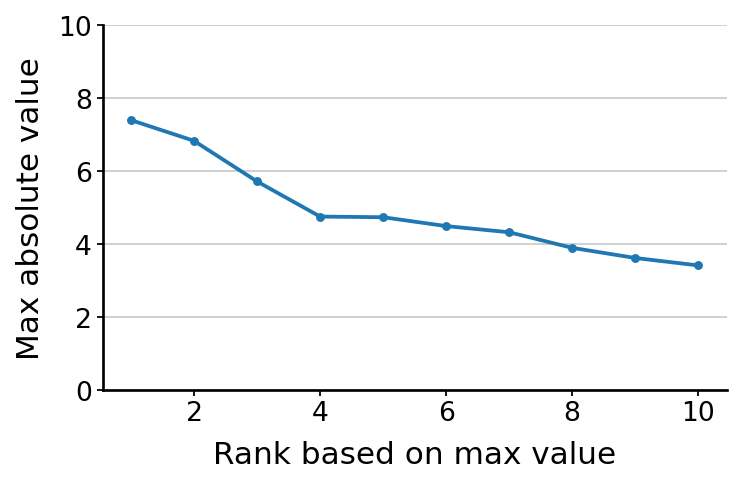

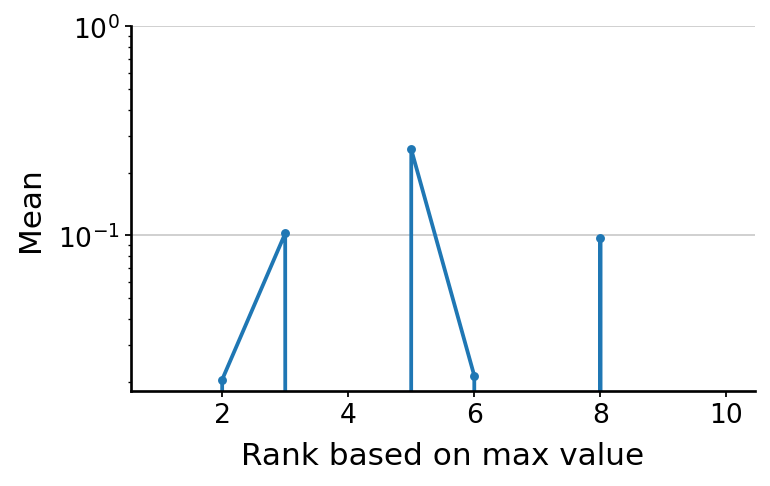

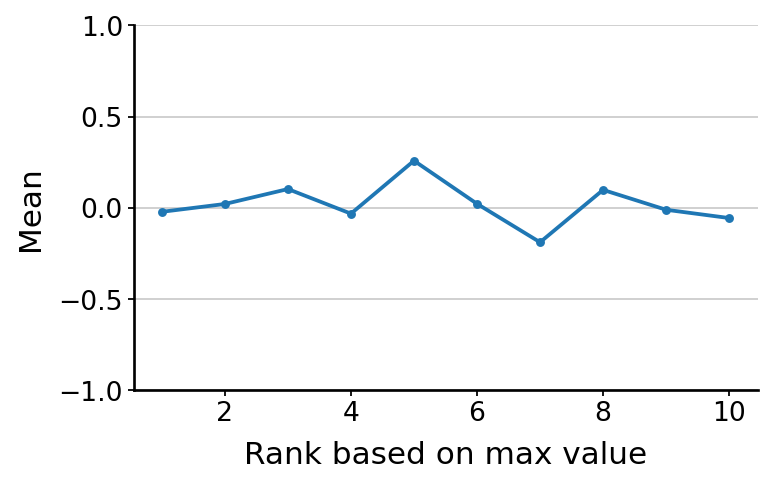

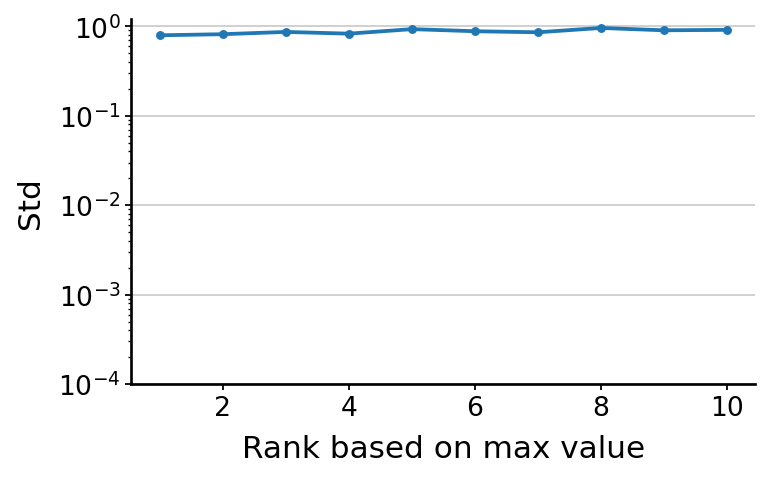

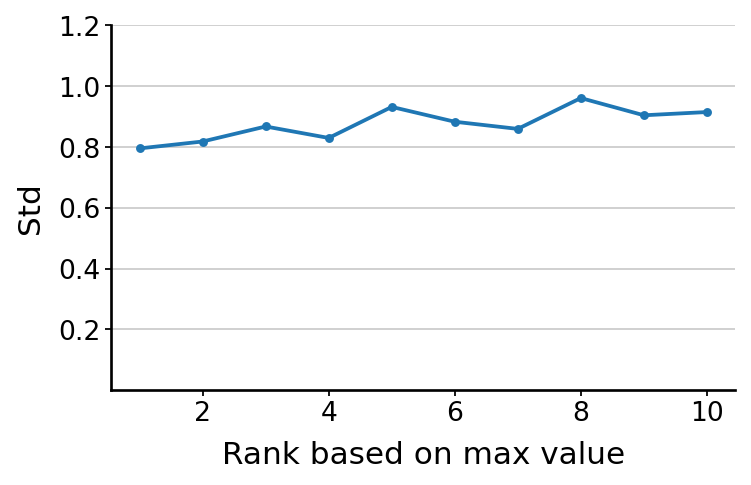

12 Dimensional


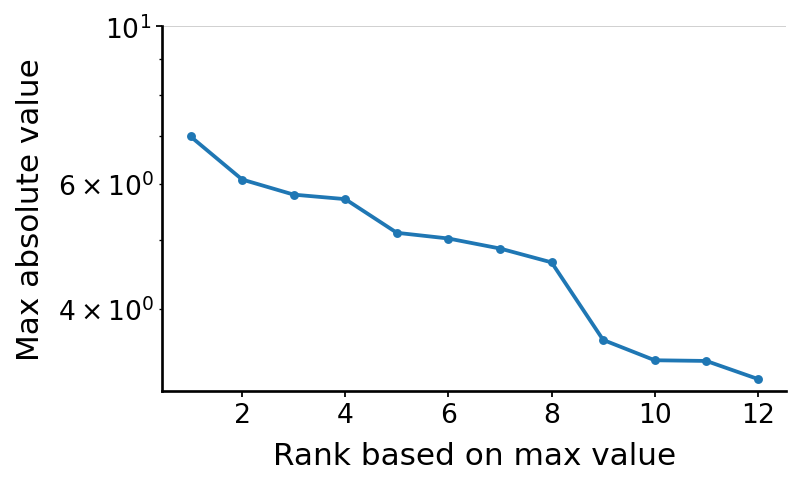

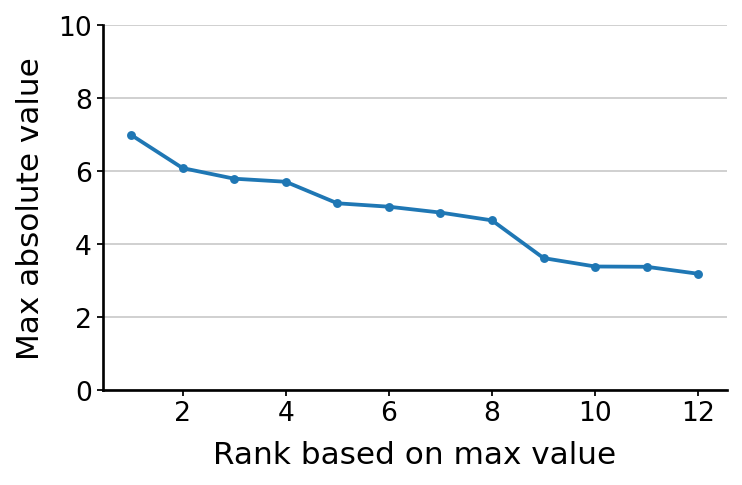

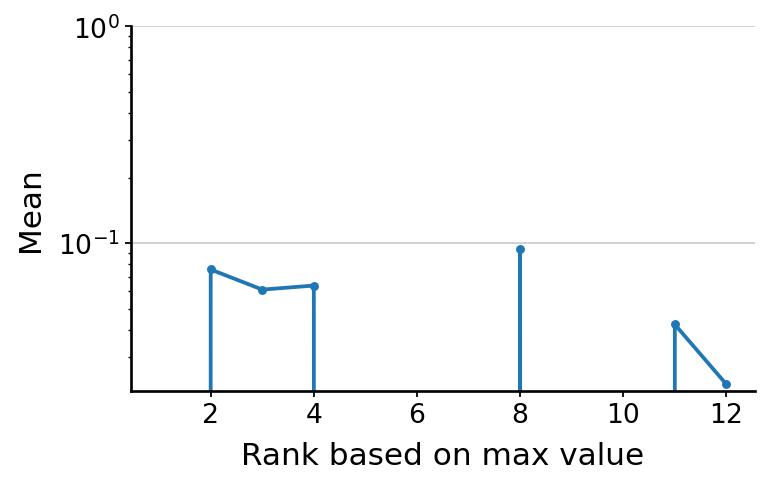

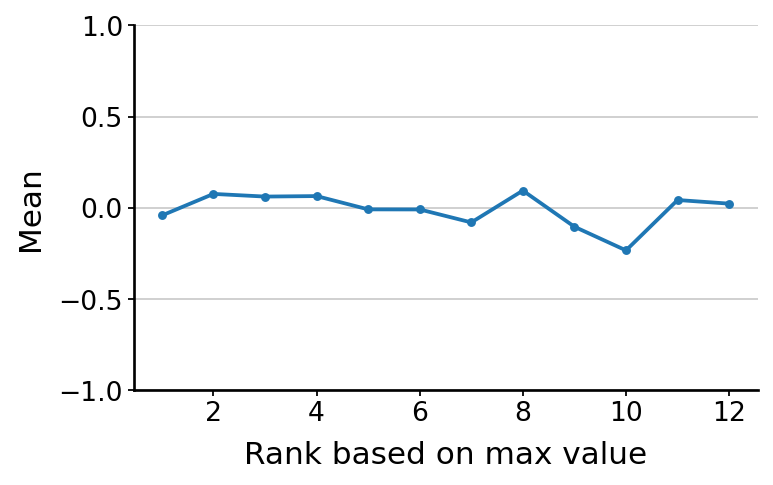

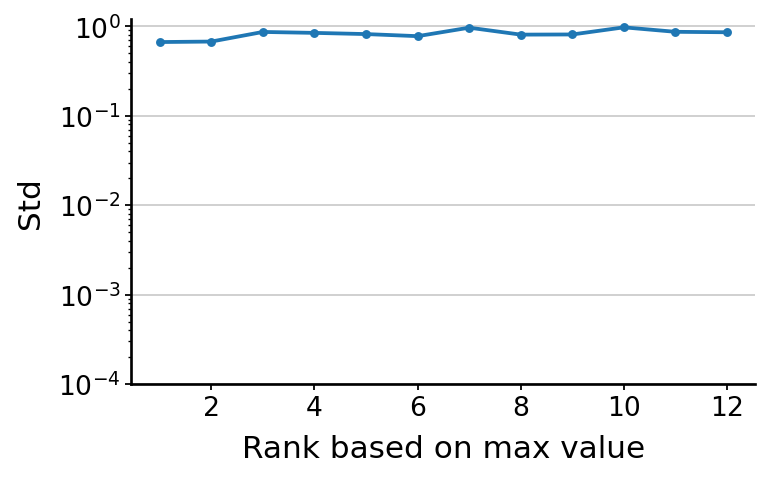

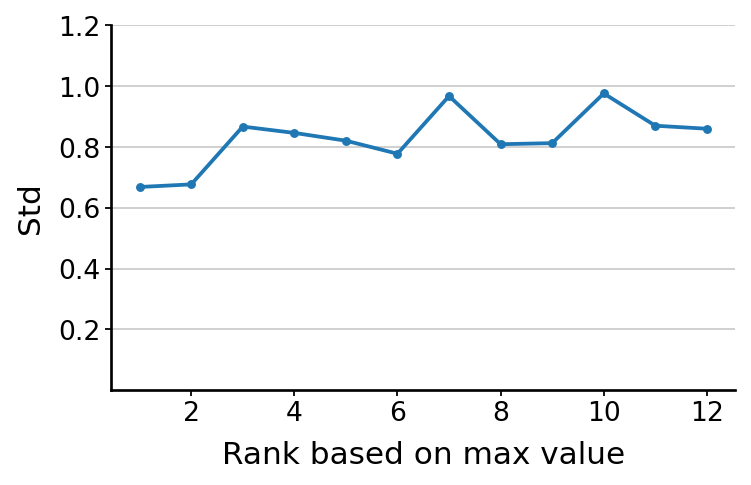

14 Dimensional


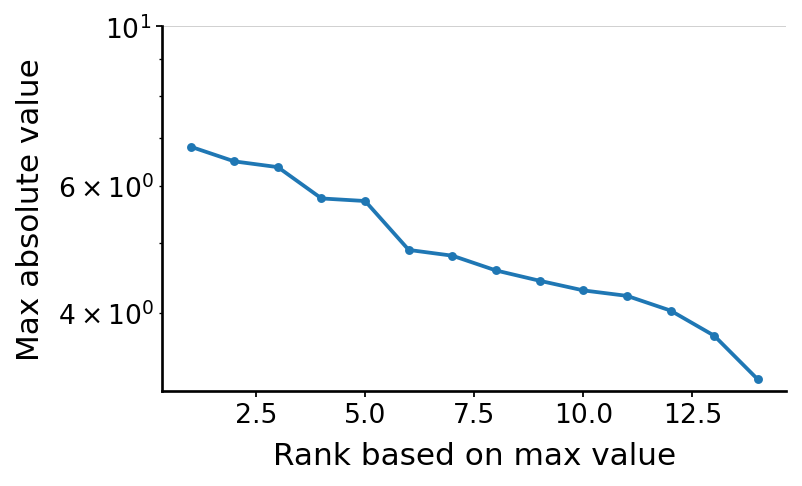

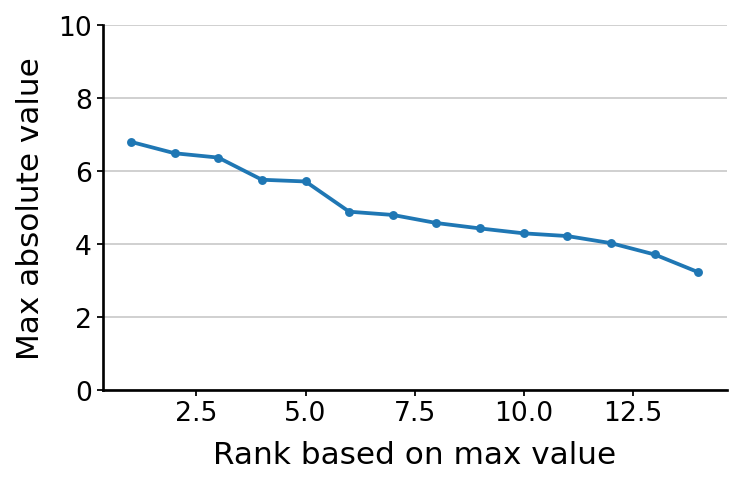

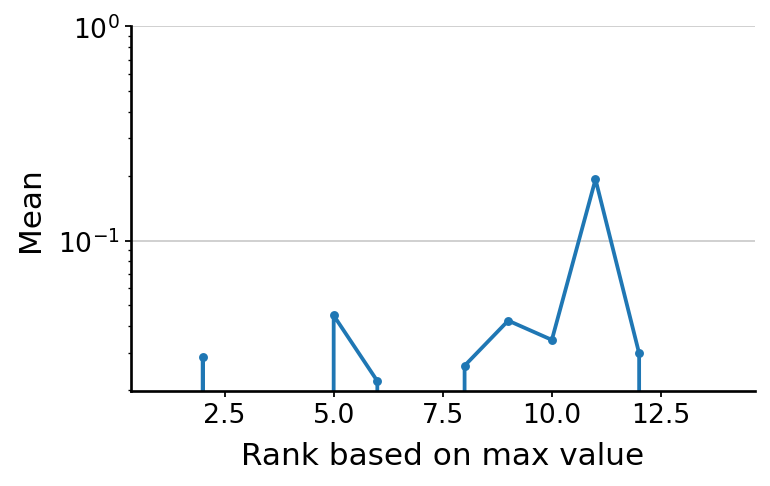

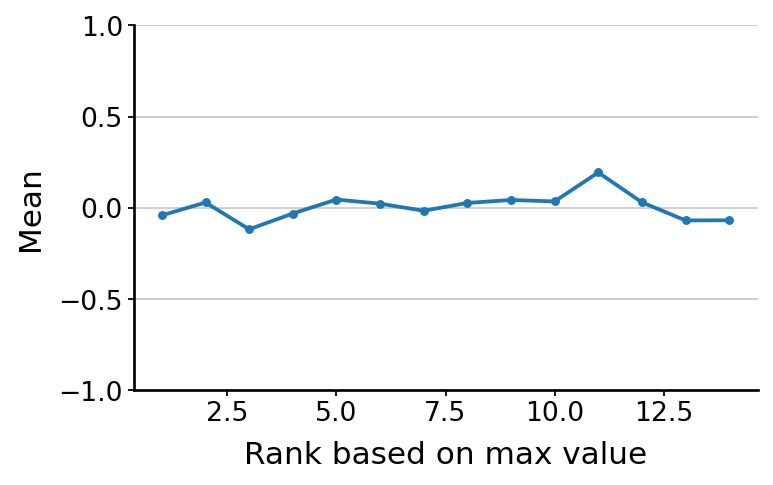

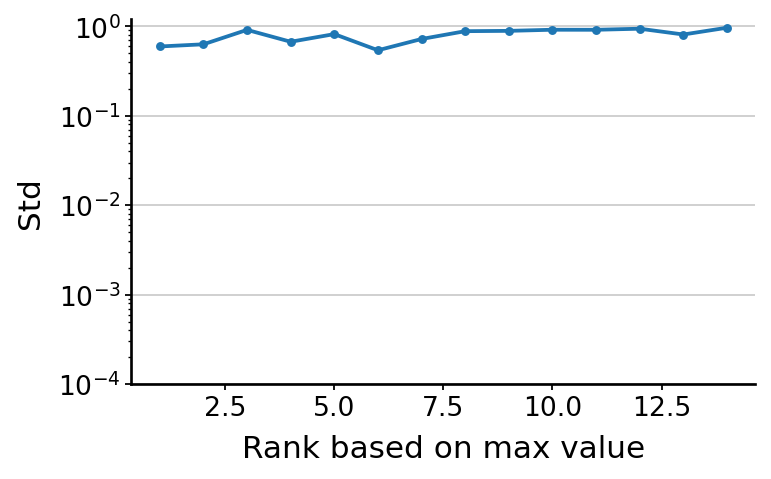

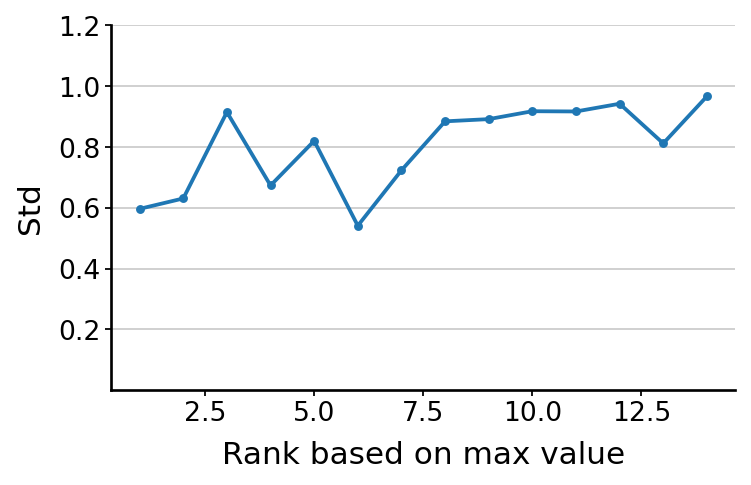

16 Dimensional


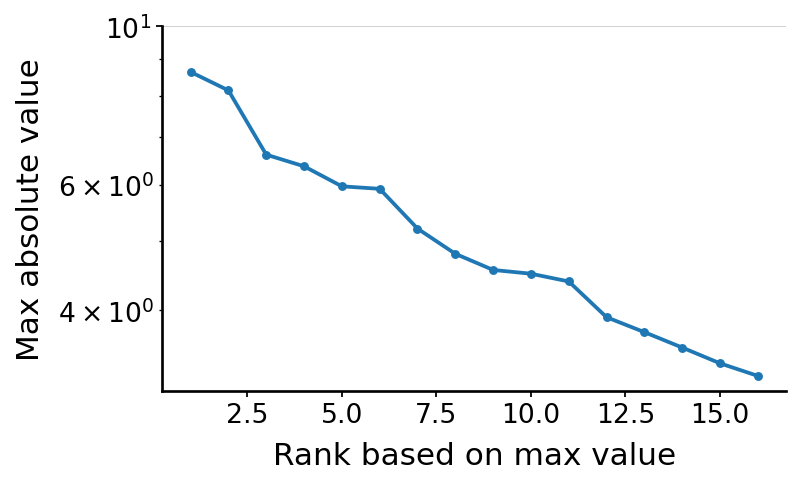

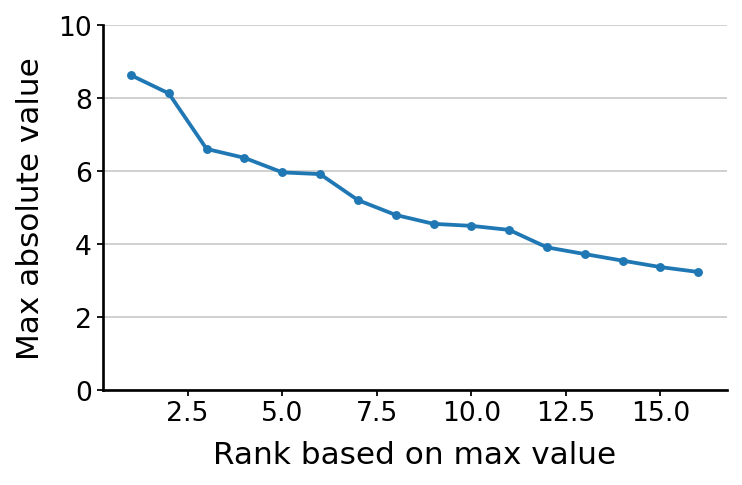

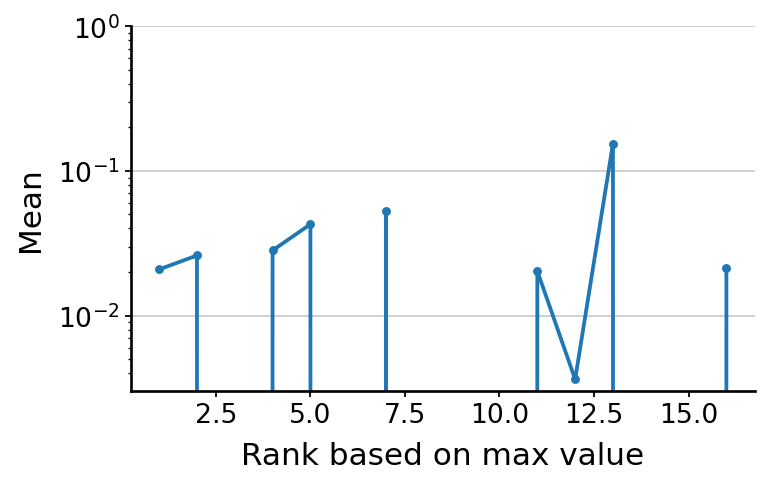

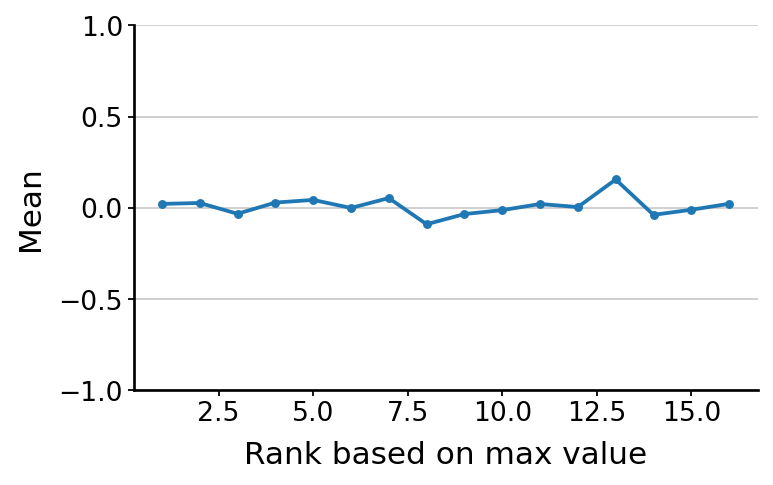

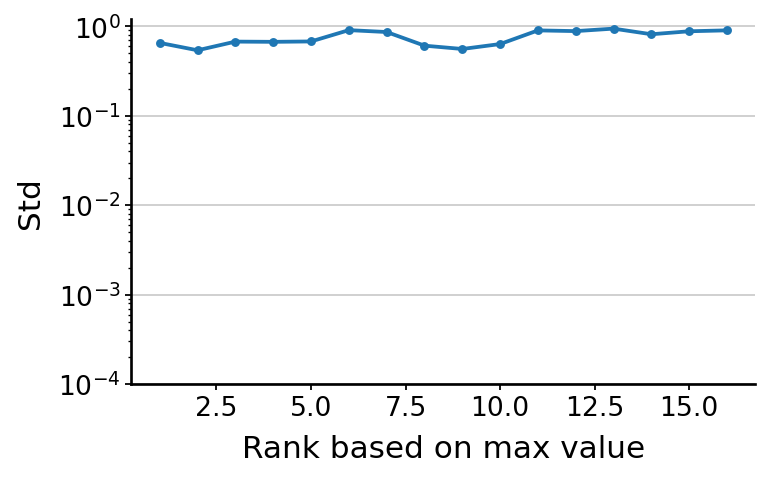

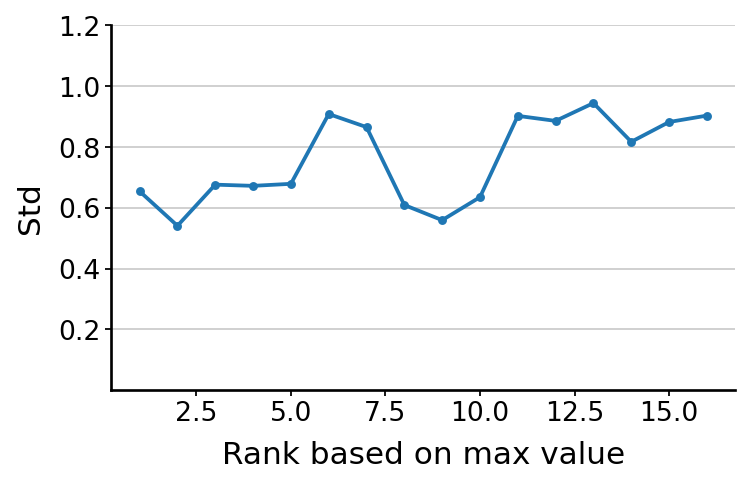

32 Dimensional


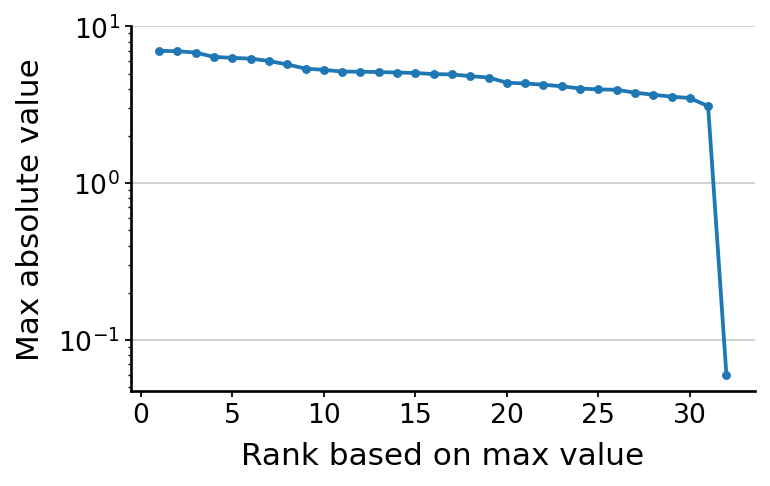

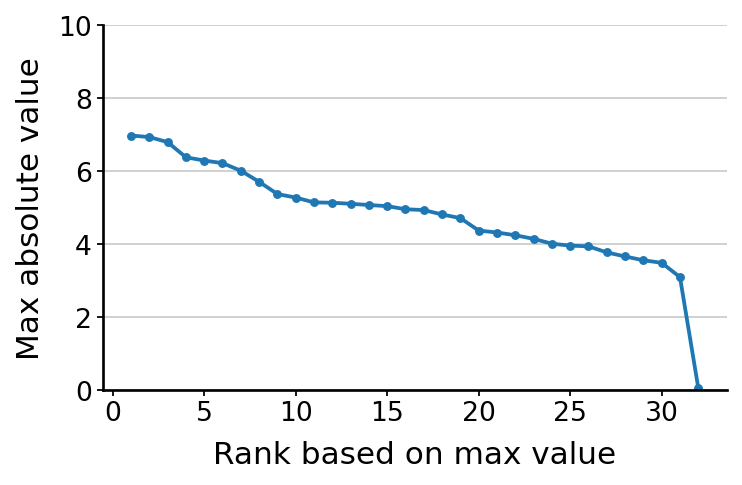

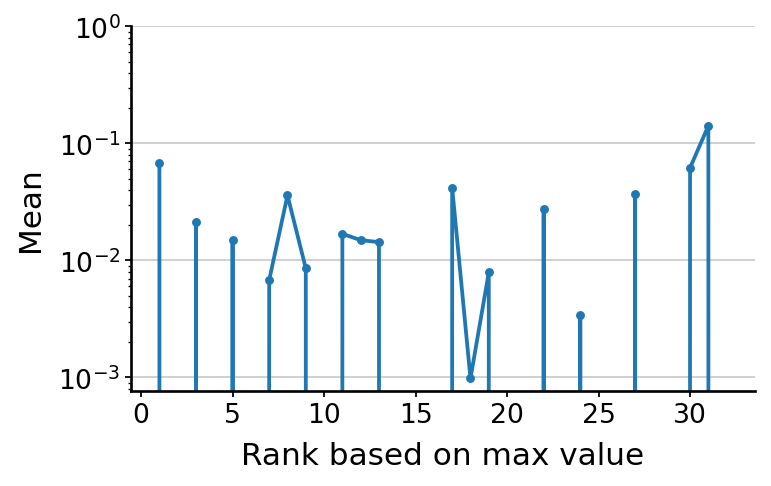

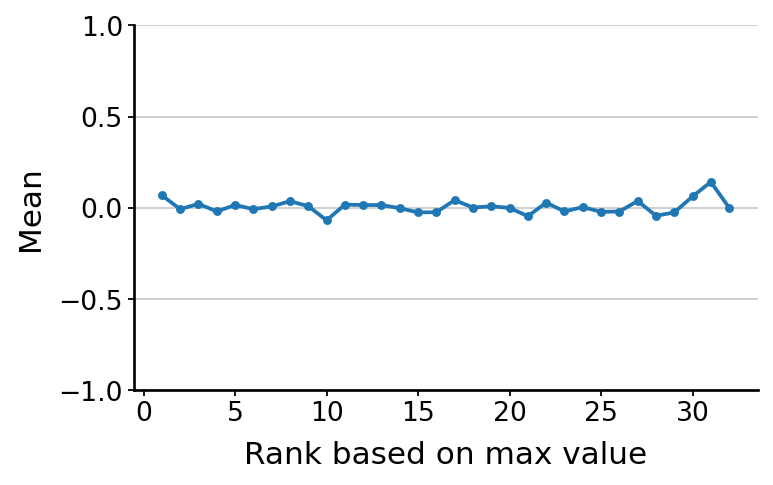

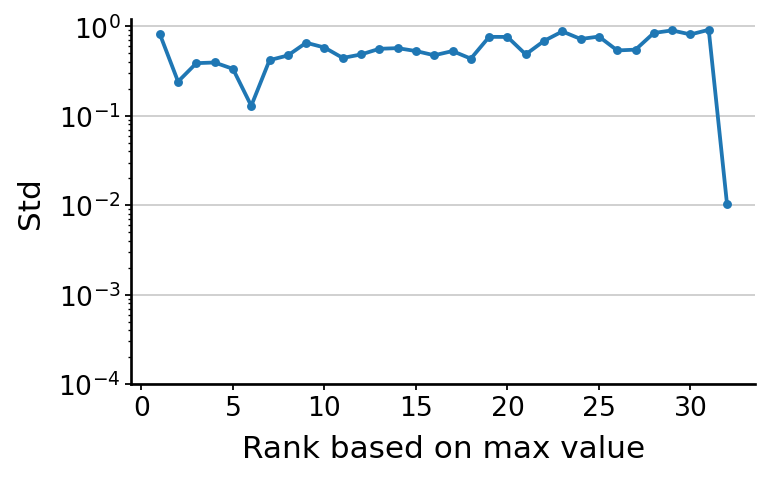

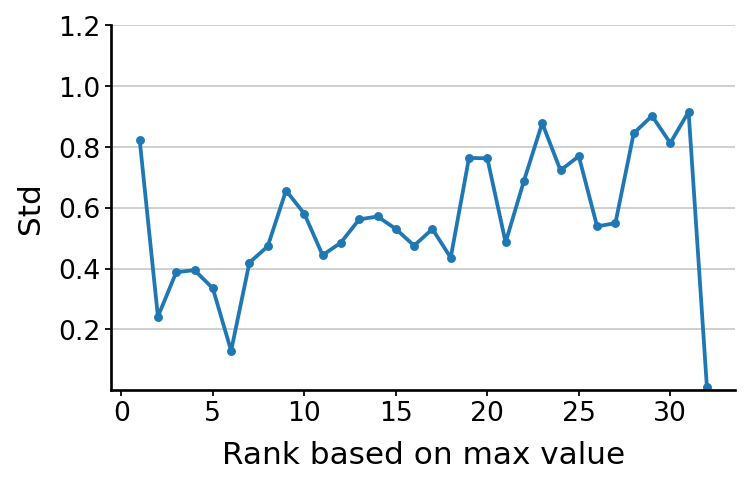

64 Dimensional


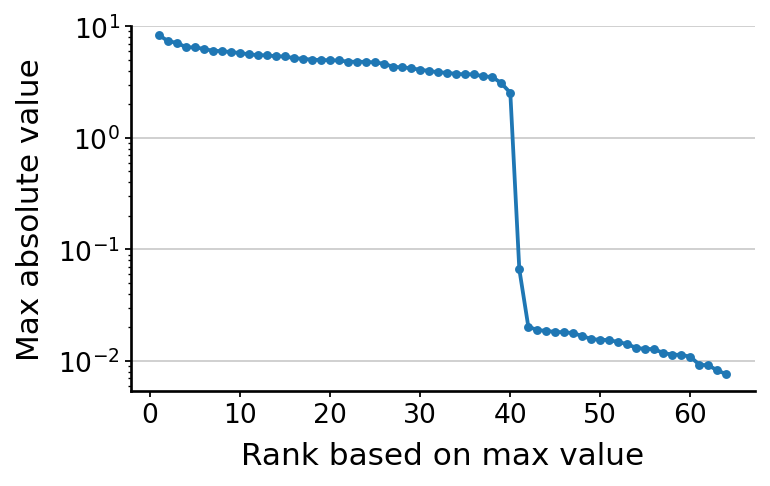

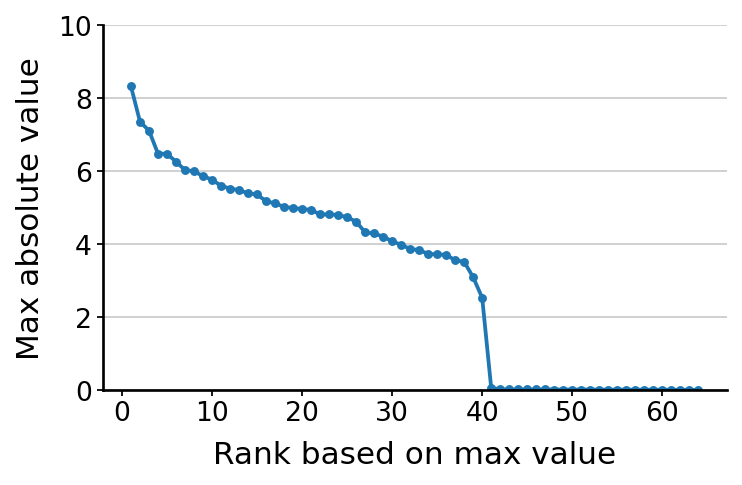

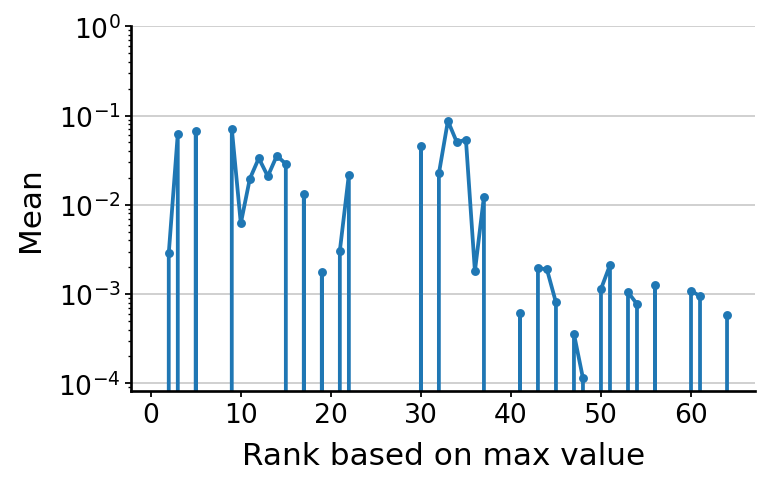

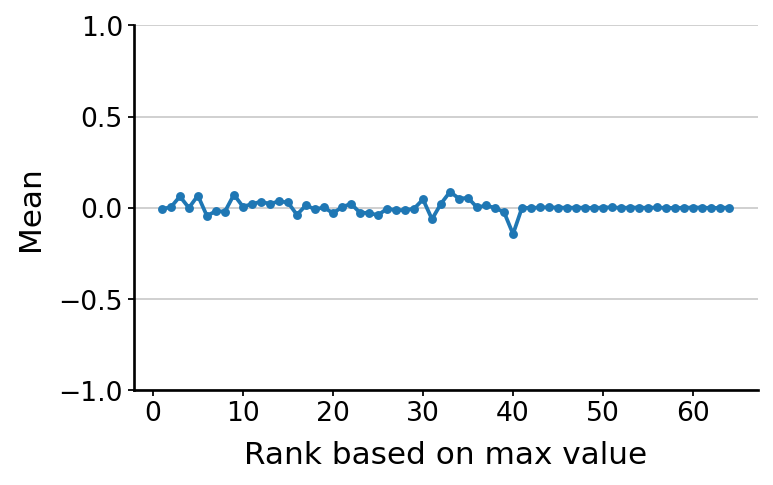

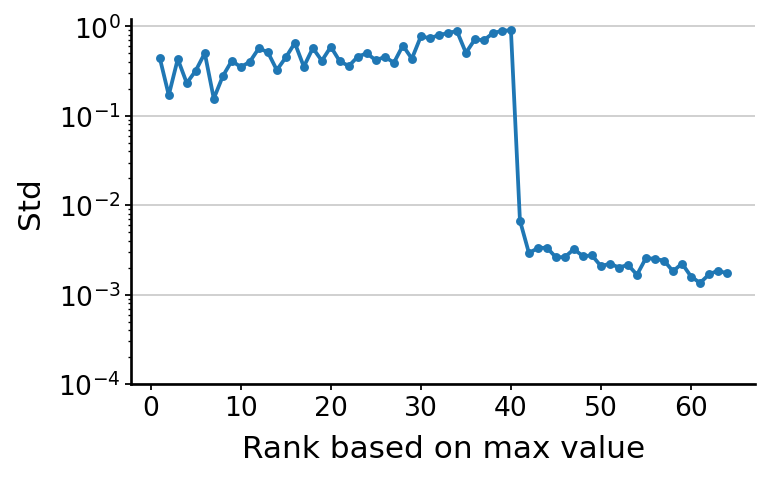

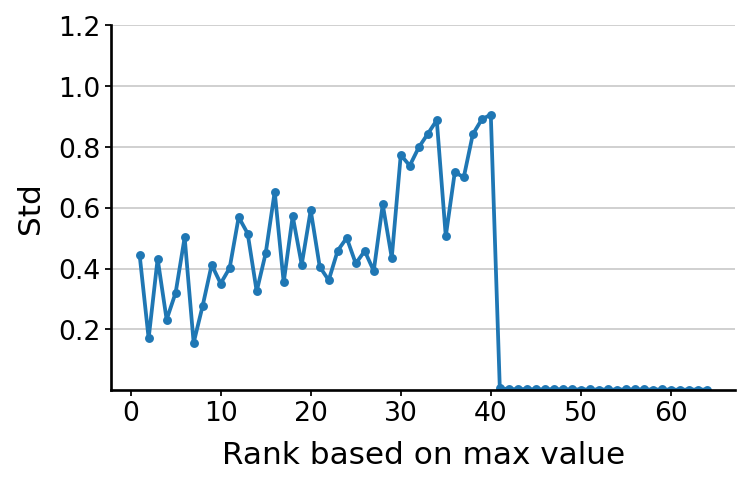

128 Dimensional


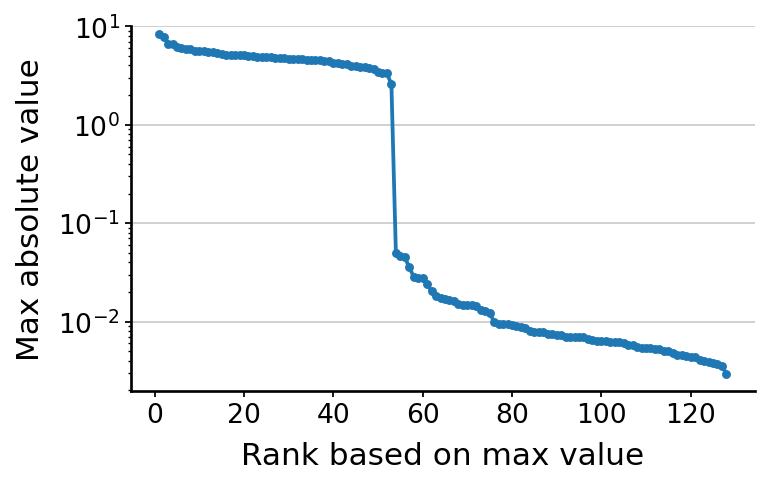

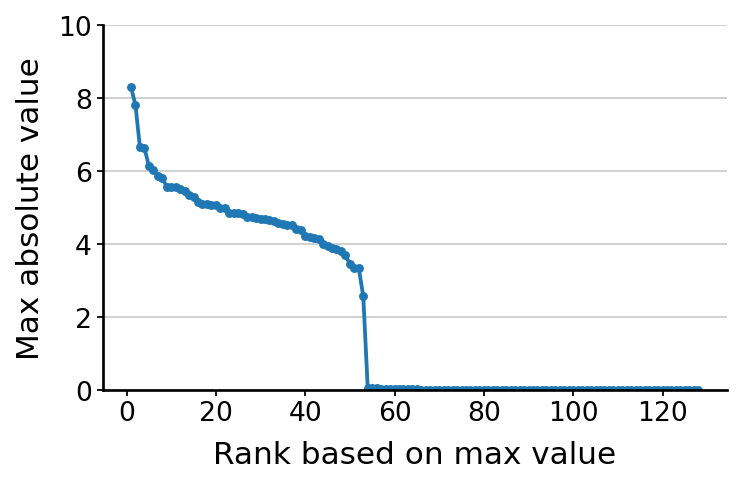

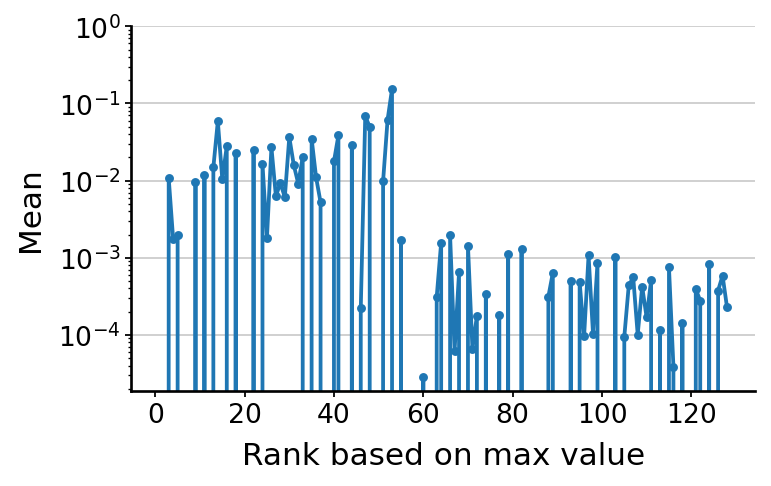

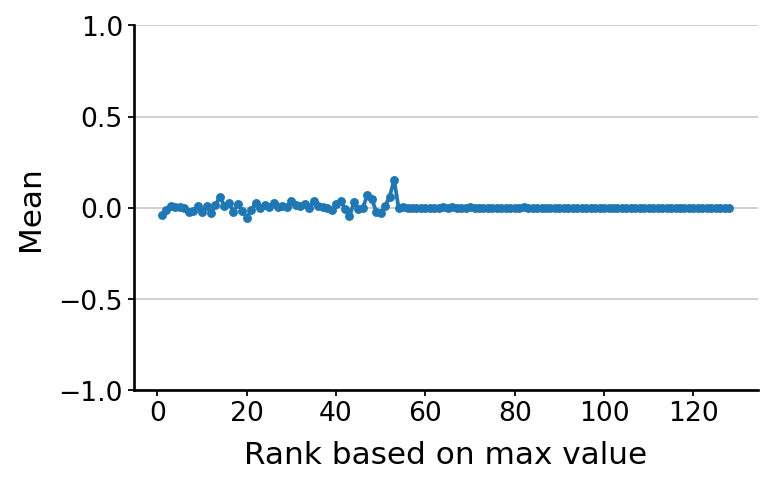

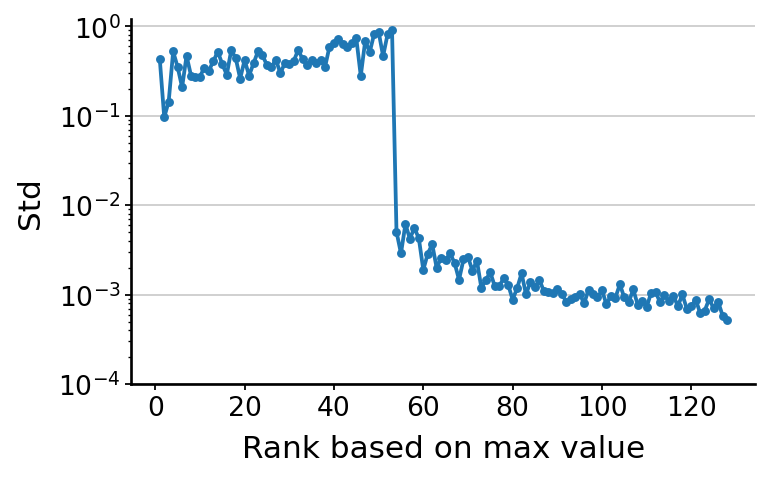

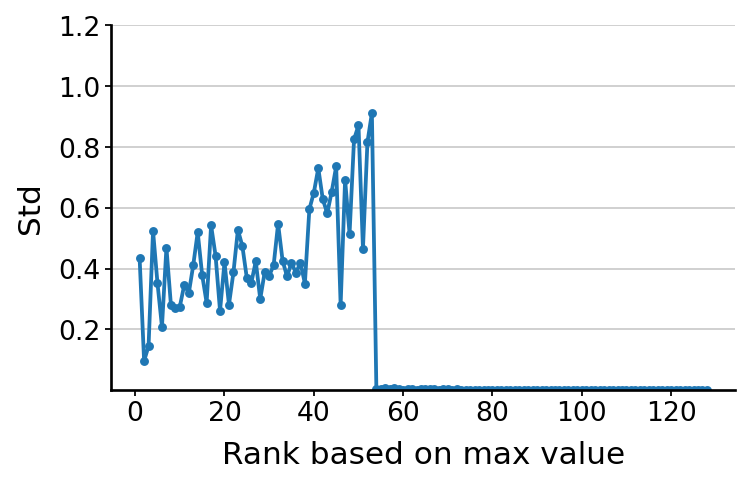

256 Dimensional


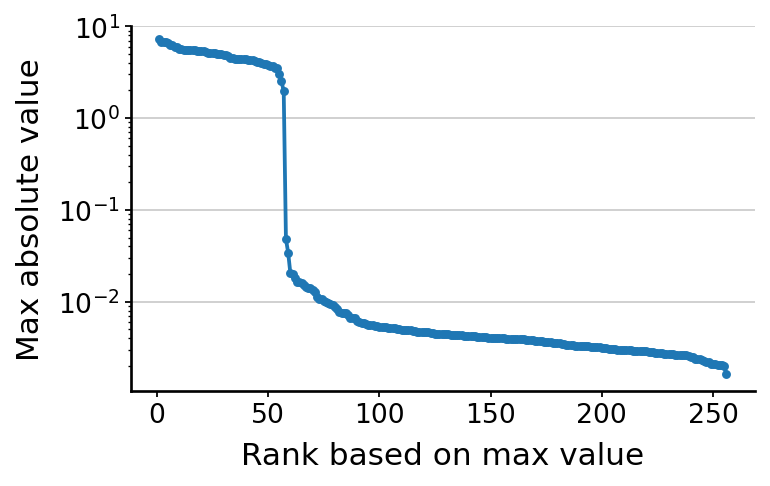

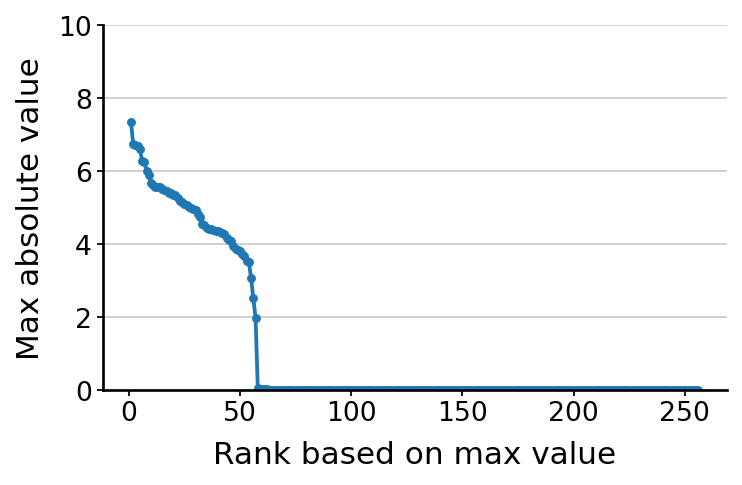

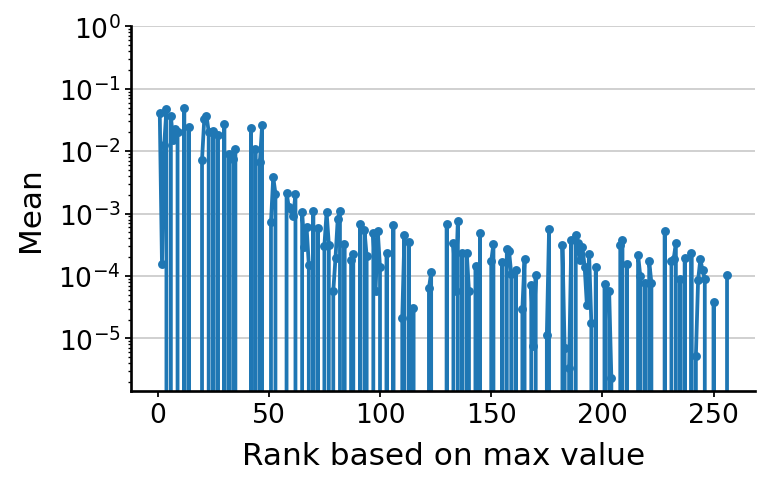

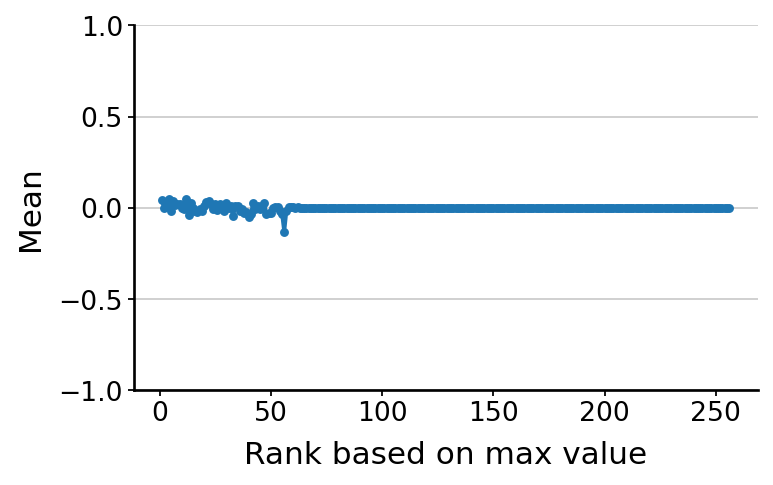

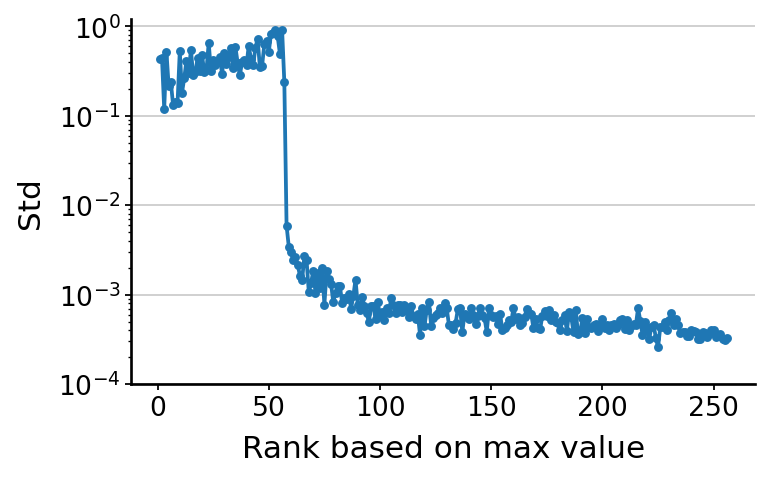

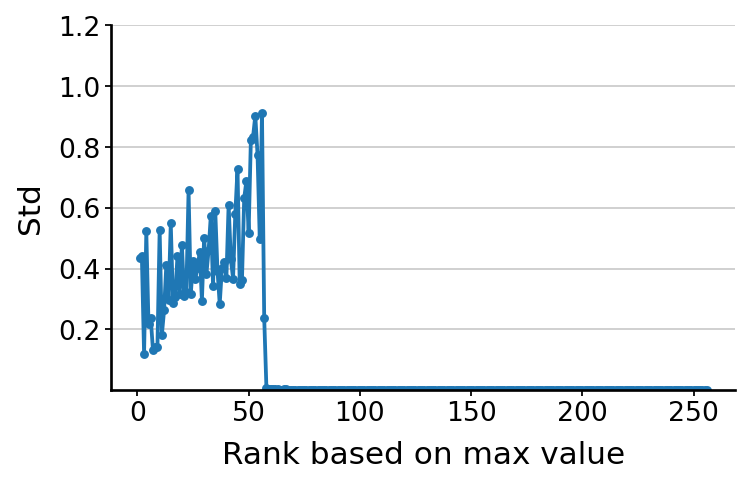

512 Dimensional


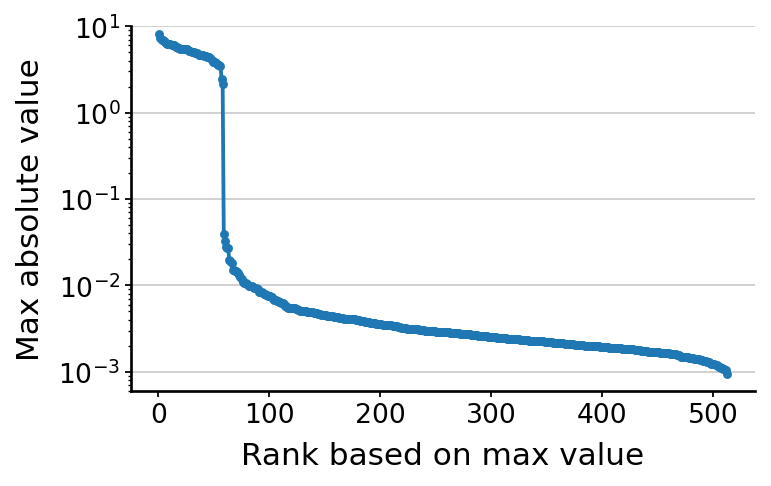

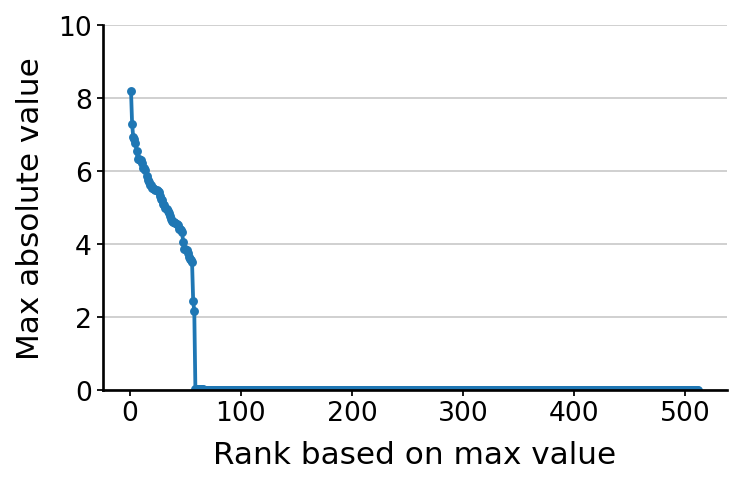

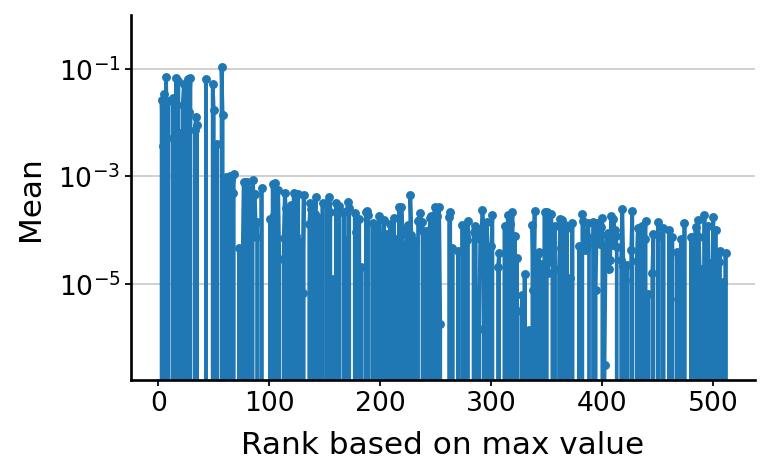

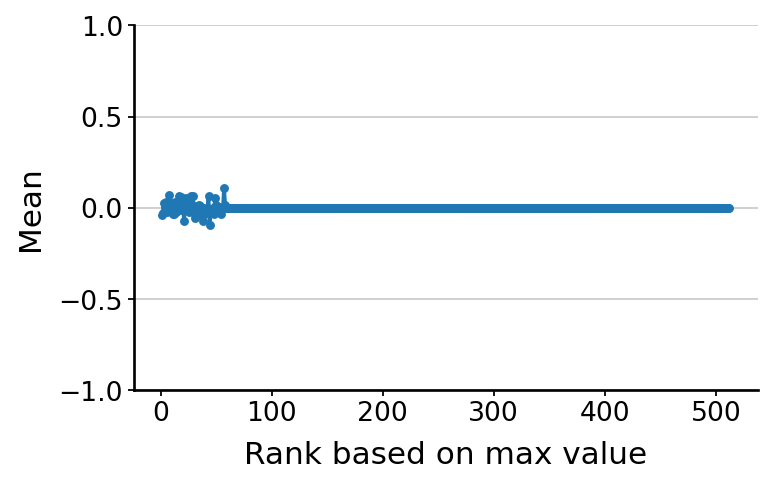

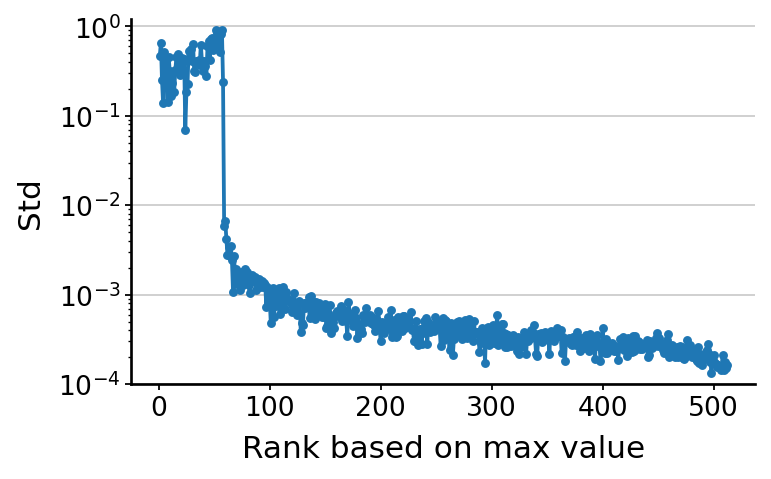

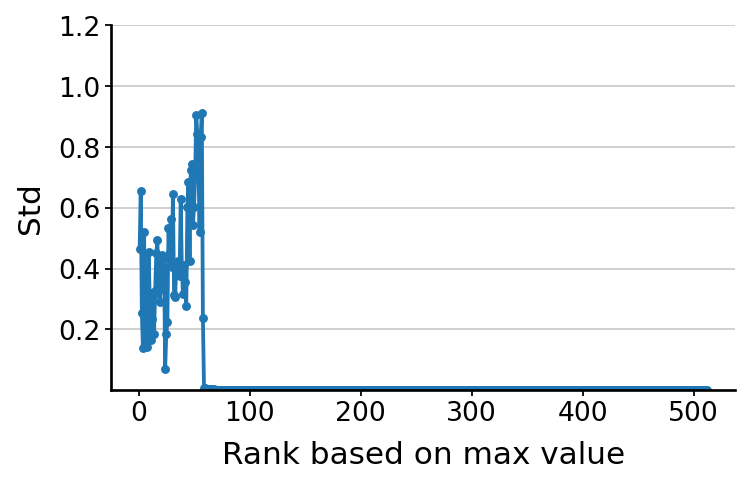

In [19]:
for method_name, embed in embeds.items():
    print(method_name)
    order = np.argsort(np.abs(embed.X).max(axis=0))[::-1]
    max_value_array = np.abs(embed.X).max(axis=0)[order]
    mean_array = embed.X.mean(axis=0)[order]
    std_array = embed.X.std(axis=0)[order]
    ranks = np.arange(1, embed.n_vars + 1)
    
    for y_axis_title, x, limits in [
        ("Max absolute value", max_value_array, (0, 10)),
        ("Mean", mean_array, (-1, 1)),
        ("Std", std_array, (0.0001, 1.2)),
    ]:
        for is_log in [True, False]:
            # Plotting the data
            plt.figure(figsize=(5, 3))
            plt.plot(ranks, x, 'o', markersize=3, color='#1F77B4', label='Data Points')  # Plot points
            plt.plot(ranks, x, linestyle='-', color='#1F77B4', label='Line')  # Solid line plot
        
            # Adding labels and title
            plt.xlabel('Rank based on max value')
            if is_log:
                plt.yscale('log')
            plt.ylabel(y_axis_title)
            plt.ylim(limits)
            
            # Adding a legend
            plt.legend().remove()
            
            # Displaying the plot
            plt.grid(axis='x')
            plt.savefig(proj_dir / 'plots' / 'immune_ablation' / f'variable_vs_rank_based_on_max_{y_axis_title}{"_log" if is_log else ""}_{method_name}.pdf', bbox_inches='tight')
            plt.show()

In [20]:
def plot_based_on_n_latent(main_df, metric, metric_title, zero_center=True):
    # Plotting the data with specific x-axis labels
    plt.figure(figsize=(5, 3))
    split_point = 80, 35
    strech_factor = 5

    xticks_labels = []
    xticks_values = []
    for i, df in enumerate([main_df.query(f"n_latent < {split_point[0]}"), main_df.query(f"n_latent >= {split_point[1]}")]):
        x = df['n_latent']
        if i == 1:
            x = split_point[0] + (x - split_point[0]) / strech_factor
        plt.plot(x, df[metric], 'o', markersize=6, color='#1F77B4')  # Plot points
        plt.plot(x, df[metric], linestyle='--', color='#1F77B4')  # Dotted line plot
        
        # Setting labels and title
        plt.xlabel('Number of latent dimensions')
        plt.ylabel(metric_title)
    
        for i, val, label in zip(range(len(x)), x, df['n_latent']):
            if val > split_point[1] or i % 4 == 0 or i == len(x) - 1:
                xticks_values.append(val)
                xticks_labels.append(str(label))
    
    # Customizing x-axis ticks to show only some of the values in n_latent
    plt.xticks(xticks_values, xticks_labels, rotation=90)
    if zero_center:
        plt.ylim(ymin=0)
    
    # Adding vertical dotted lines for each n_latent value
    for val in xticks_values:
        plt.axvline(x=val, linestyle=':', color='grey', zorder=-10)
    
    # Add splitting lines
    plt.axvline(x=69, linestyle='-', color='black')
    plt.axvline(x=72, linestyle='-', color='black')
    
    # Displaying the plot
    plt.grid(False)
    return plt

In [21]:
embed_names_list = list(embeds.keys())
plot_df = pd.DataFrame(
    {
        'n_latent': [int(x.split(" ")[0]) for x in embed_names_list],
        'n_non_vanished': [(np.abs(embeds[x].X).max(axis=0) > 1).sum() for x in embed_names_list],
    }
)
plot_df.T

0   1   2   3   4   5   6   7   8   9    10   11   12
n_latent         2   4   6   8  10  12  14  16  32  64  128  256  512
n_non_vanished   2   4   6   8  10  12  14  16  31  40   53   57   58

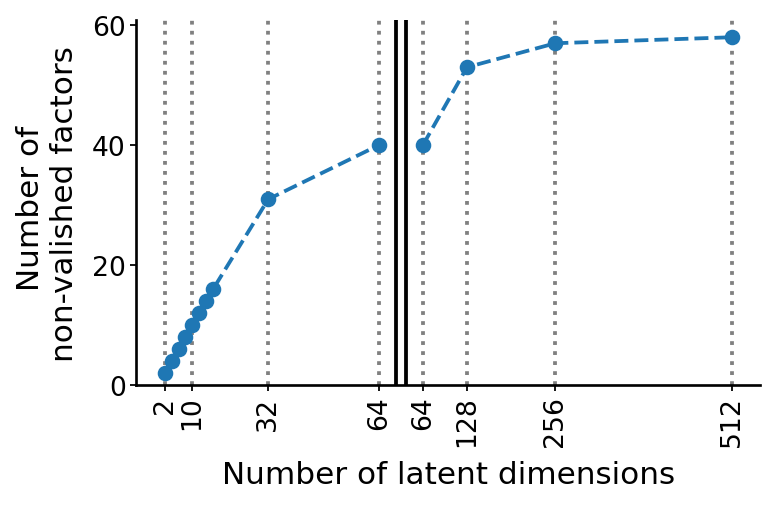

In [22]:
metric = 'n_non_vanished'
plt = plot_based_on_n_latent(plot_df.copy(), metric, 'Number of \nnon-valished factors')
plt.savefig(proj_dir / 'plots' / 'immune_ablation' / f'{metric}_vs_n_latent.pdf', bbox_inches='tight')
plt.show()

# Disentanglement comparison

In [23]:
######################################
# Please run disentanglemnt notebook #
######################################

In [24]:
metric_abbr = {
    'Absolute Spearman Correlation': 'ASC',
    'Mutual Info Score': 'SMI',
    'NN Alignment': 'SPN',
}
disentanglement_results = []
for metric_aggregation_type in ['LMS', 'MSAS', 'MSGS']:
    results_df = pd.read_csv(proj_dir / 'results' / f'eval_disentanglement_immune_hvg_ablation_{metric_aggregation_type}.csv')
    results_df['aggregation_type'] = metric_aggregation_type
    results_df['metric_short_name'] = metric_aggregation_type + "-" + results_df['metric'].map(metric_abbr).astype(str)
    disentanglement_results.append(results_df)

disentanglement_results = pd.concat(disentanglement_results)
disentanglement_results

metric  2 Dimensional  4 Dimensional  6 Dimensional  \
0  Absolute Spearman Correlation       0.087089       0.131815       0.172918   
1                   NN Alignment       0.101261       0.203668       0.257684   
2              Mutual Info Score       0.102649       0.215519       0.267998   
0  Absolute Spearman Correlation       0.209809       0.289566       0.283820   
1                   NN Alignment       0.489969       0.578918       0.444399   
2              Mutual Info Score       0.632518       0.661660       0.561661   
0  Absolute Spearman Correlation       0.074981       0.133446       0.104150   
1                   NN Alignment       0.250663       0.447577       0.273178   
2              Mutual Info Score       0.224384       0.419697       0.264824   

   8 Dimensional  10 Dimensional  12 Dimensional  14 Dimensional  \
0       0.228969        0.234995        0.267373        0.278689   
1       0.362569        0.502101        0.506768        0.542209   
2       0.380397        0.512367        0.535436        0.585372   
0       0.304355        0.302639        0.308588        0.302790   
1       0.519005        0.677407        0.691675        0.654833   
2       0.615812        0.735087        0.731142        0.713667   
0       0.094767        0.106790        0.095597        0.067022   
1       0.325231        0.518851        0.490853        0.435117   
2       0.315984        0.482683        0.433376        0.402429   

   16 Dimensional  32 Dimensional  64 Dimensional  128 Dimensional  \
0        0.297087        0.302808        0.310417         0.300501   
1        0.610139        0.657006        0.684935         0.686474   
2        0.645140        0.699132        0.725238         0.708577   
0        0.307886        0.303993        0.310417         0.300501   
1        0.687311        0.687140        0.684935         0.686474   
2        0.724119        0.716229        0.725238         0.708577   
0        0.075835        0.044425        0.028144         0.017910   
1        0.436905        0.333580        0.289942         0.183582   
2        0.385264        0.260172        0.212754         0.123172   

   256 Dimensional  512 Dimensional aggregation_type metric_short_name  
0         0.303828         0.309754              LMS           LMS-ASC  
1         0.690147         0.690553              LMS           LMS-SPN  
2         0.714494         0.720123              LMS           LMS-SMI  
0         0.303828         0.309754             MSAS          MSAS-ASC  
1         0.690147         0.690553             MSAS          MSAS-SPN  
2         0.714494         0.720123             MSAS          MSAS-SMI  
0         0.018336         0.016282             MSGS          MSGS-ASC  
1         0.168878         0.159506             MSGS          MSGS-SPN  
2         0.129782         0.115937             MSGS          MSGS-SMI

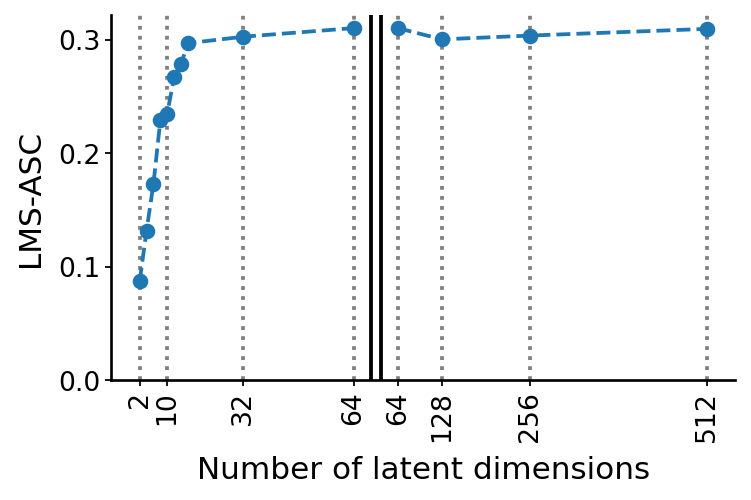

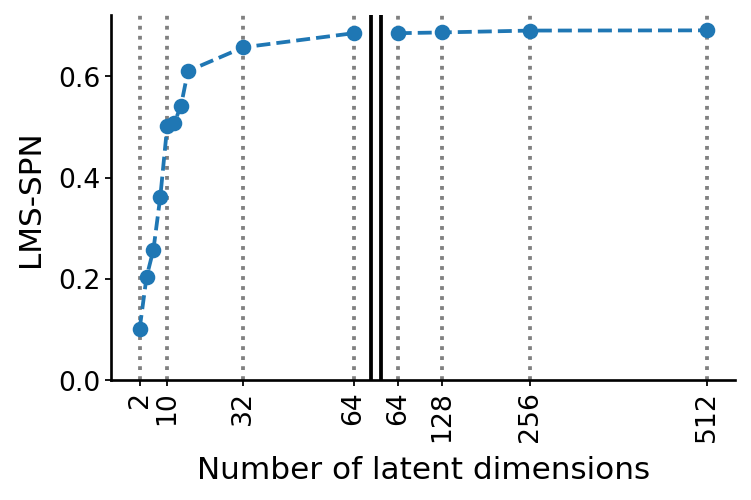

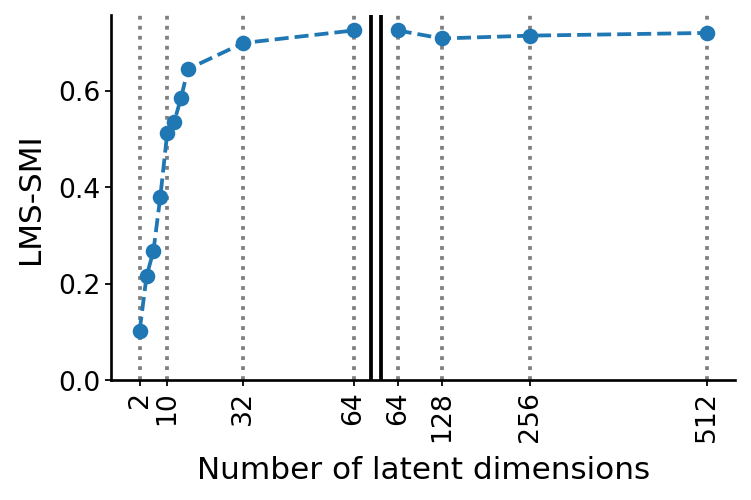

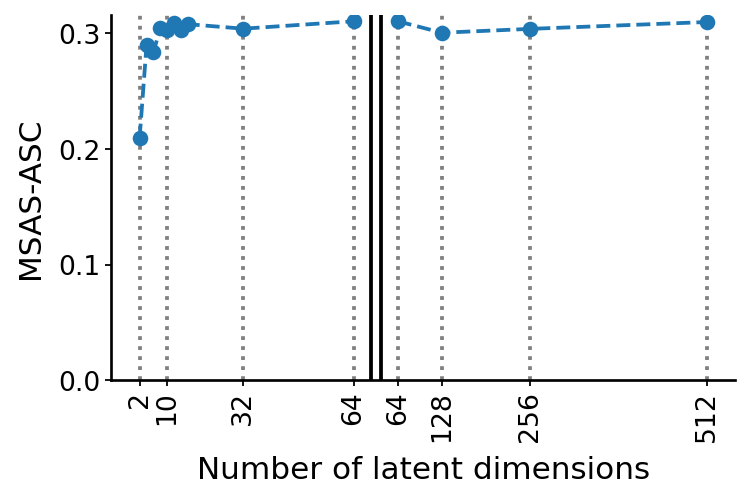

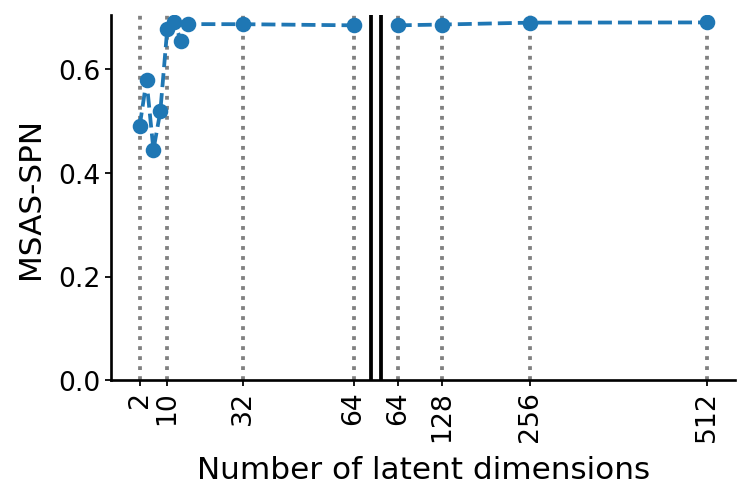

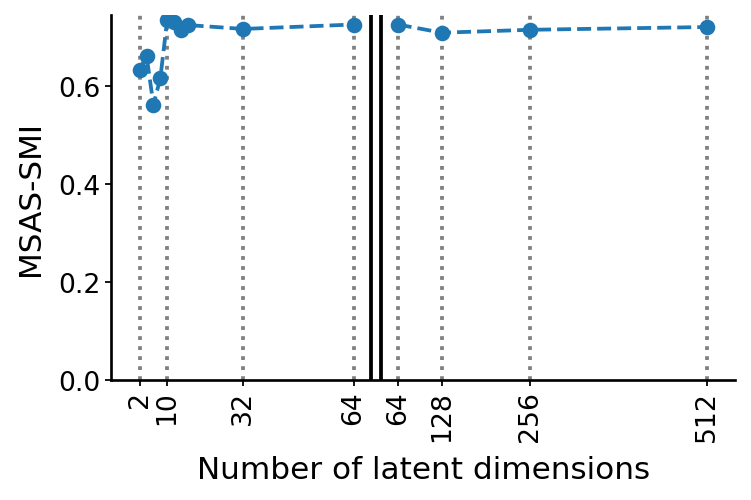

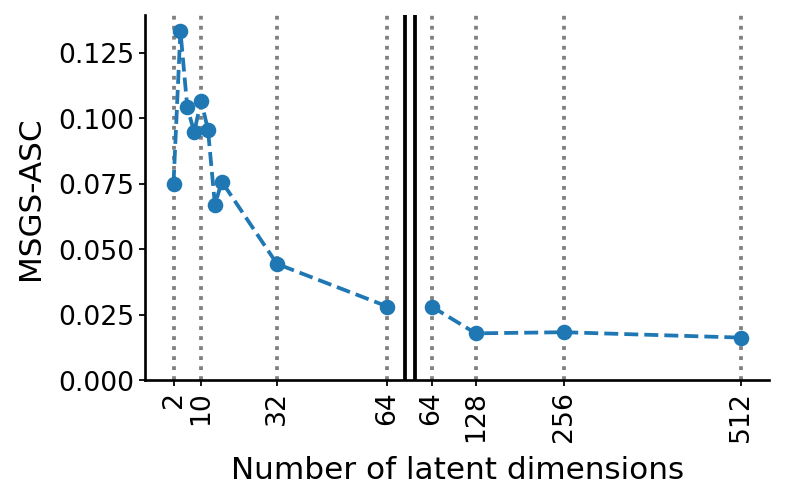

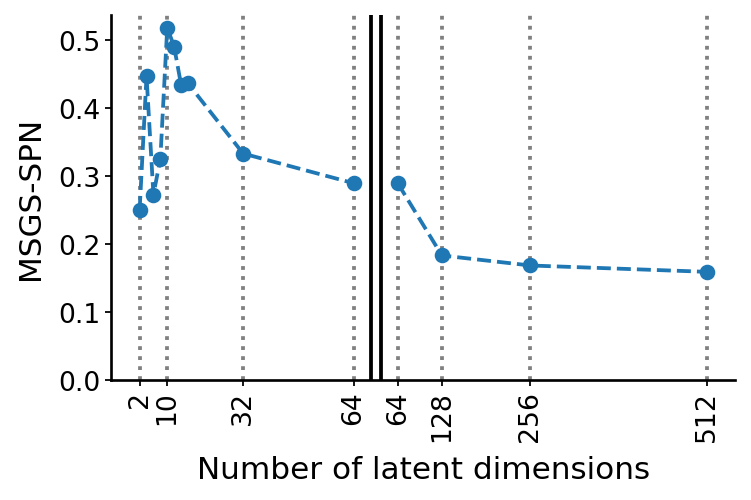

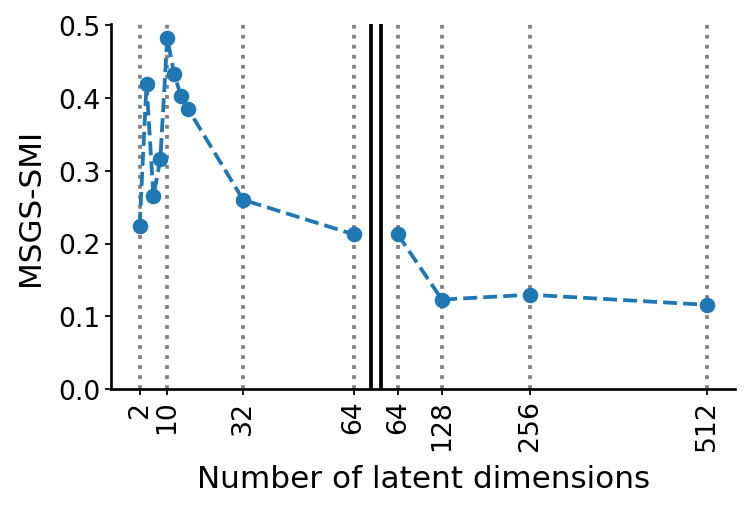

In [25]:
df = disentanglement_results.set_index('metric_short_name')
df = df.loc[:, df.columns.str.contains('Dimensional')].T
df['n_latent'] = df.index.str.split(" ").str[0].astype(int)
df
for metric in df.columns:
    if "-" not in metric:
        continue

    plt = plot_based_on_n_latent(df.copy(), metric, metric)
    plt.savefig(proj_dir / 'plots' / 'immune_ablation' / f'{metric}_vs_n_latent.pdf', bbox_inches='tight')
    plt.show()

# Integrattion quality comparison

In [26]:
methods_to_consider = ["DRVI", "DRVI-AP", "scVI", "PCA", "ICA", "MICHIGAN", "B-TCVAE", "MOFA"]

In [27]:
scib_results_address = proj_dir / 'results' / f'scib_results_immune_hvg_ablation.csv'
scib_df = pd.read_csv(scib_results_address, index_col=0).reset_index(names='method')
scib_df = scib_df[['method', 'Bio conservation', 'Batch correction', 'Total']]
scib_df['n_latent'] = scib_df['method'].str.split(" ").str[0].astype(int)
scib_df

method  Bio conservation  Batch correction     Total  n_latent
0     2 Dimensional          0.611250          0.516728  0.573441         2
1     4 Dimensional          0.670454          0.600849  0.642612         4
2     6 Dimensional          0.645321          0.560028  0.611204         6
3     8 Dimensional          0.677603          0.598157  0.645825         8
4    10 Dimensional          0.650500          0.598642  0.629757        10
5    12 Dimensional          0.674997          0.592058  0.641821        12
6    14 Dimensional          0.680666          0.620936  0.656774        14
7    16 Dimensional          0.679574          0.604556  0.649567        16
8    32 Dimensional          0.680854          0.614253  0.654214        32
9    64 Dimensional          0.681486          0.617073  0.655721        64
10  128 Dimensional          0.668667          0.611824  0.645930       128
11  256 Dimensional          0.701033          0.608188  0.663895       256
12  512 Dimensional          0.695743          0.602645  0.658504       512

In [28]:
scib_methods = pd.read_csv(proj_dir / 'results' / f'scib_results_immune_hvg.csv', index_col=0).reset_index(names='method')
scib_methods = scib_methods[['method', 'Bio conservation', 'Batch correction', 'Total']]
scib_methods = scib_methods[(scib_methods['method'].isin(methods_to_consider))]
scib_methods

method  Bio conservation  Batch correction     Total
0      DRVI          0.680854          0.614253  0.654214
1   DRVI-AP          0.695513          0.609093  0.660945
2      scVI          0.631901          0.649010  0.638744
3       PCA          0.670771          0.369927  0.550434
4       ICA          0.663739          0.433320  0.571572
5      MOFA          0.673531          0.388968  0.559706
6   B-TCVAE          0.640128          0.413461  0.549462
7  MICHIGAN          0.465279          0.652472  0.540156

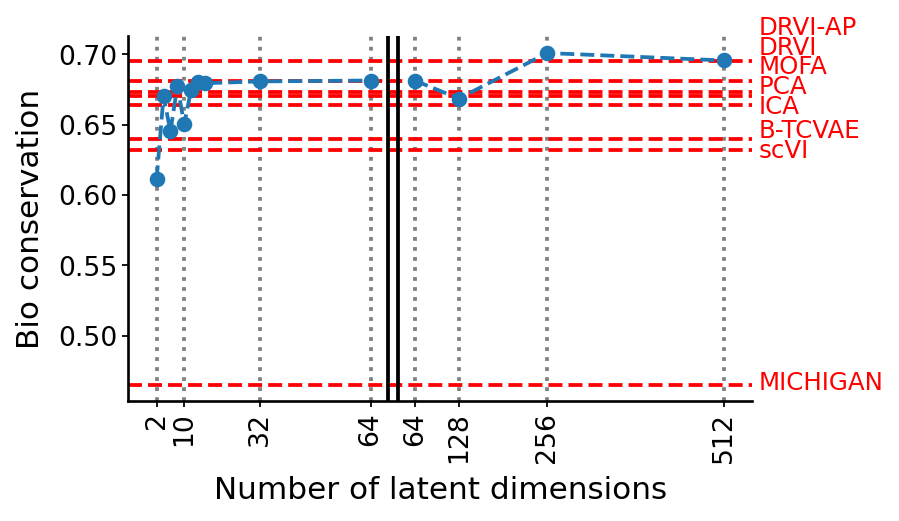

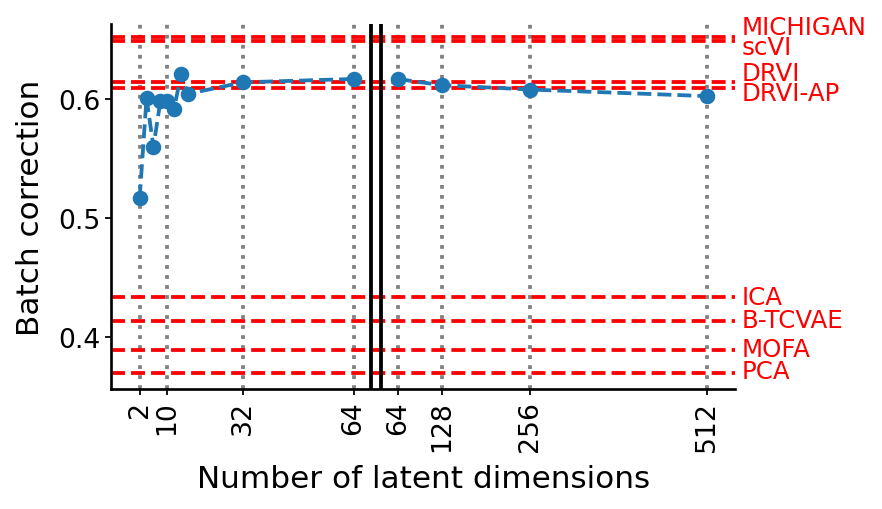

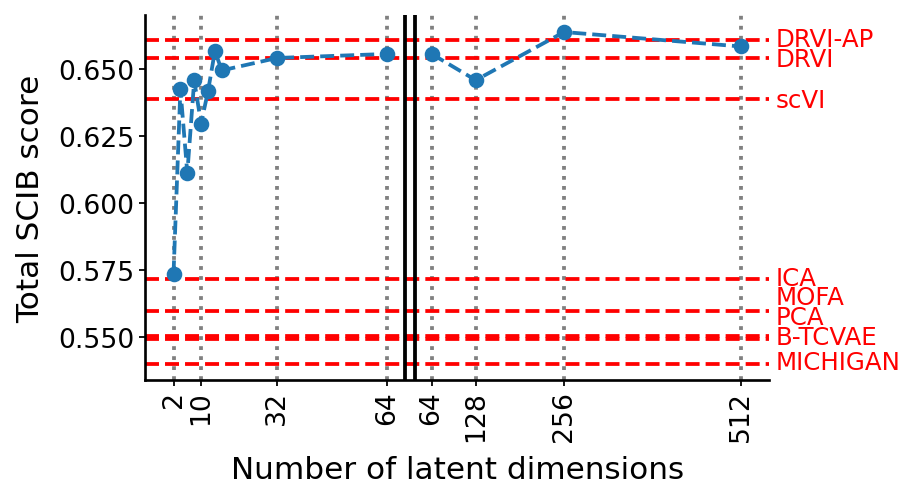

In [29]:
for metric in scib_df.columns:
    if metric in ['n_latent', 'method']:
        continue

    plt = plot_based_on_n_latent(scib_df.copy(), metric, metric, zero_center=False)
    prev_y = 0
    y_min = min(scib_methods[metric].min(), scib_df[metric].min())
    y_length = max(scib_methods[metric].max(), scib_df[metric].max()) - y_min
    for row in scib_methods.sort_values(metric).iterrows():
        bias = 0
        if row[1][metric] - prev_y < 0.06 * y_length:
            bias = 0.06 * y_length - row[1][metric] + prev_y
        plt.axhline(y=row[1][metric], linestyle='--', color='red', zorder=-10)
        plt.text(1.01, 0.05 + 0.9 * (row[1][metric] + bias - scib_methods[metric].min()) / y_length,
                 row[1]['method'], color='red', horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
        prev_y = row[1][metric] + bias
    if metric == 'Total':
        plt.ylabel('Total SCIB score')
    plt.savefig(proj_dir / 'plots' / 'immune_ablation' / f'scib_{metric}_vs_n_latent.pdf', bbox_inches='tight')
    plt.show()